# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

# ¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



# Proyecto 04 - Modelando la Pandemia

#### Implementación de un Sistema de Recomendación para videojuegos de la plataforma Steam.

En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](https://ourworldindata.org/coronavirus-data?country=)

Este proyecto se puede encontrar en mi **[github](https://github.com/gonzalogperez/informe_pandemico)**

In [1]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

### Tabla de Contenidos <a class="anchor" id="TOC"></a>

* [Exploración de Datos](#chapter1)
    * [a. Explora la fuente de datos](#section_1_1)
    * [b. Análisis exploratorio](#section_1_2)
        * [b.1 Tomar datos de un pais en particular](#section_1_2_1)
        * [b.2 Seleccionar la etapa de primer crecimiento exponencial de la curva](#section_1_2_2)
        * [b.3 Extraer el k de crecimiento exponencial y comparar el modelo con los datos reales para el pais elegido](#section_1_2_3)
        * [b.4 Evolución de los casos de Covid en distintos paises](#section_1_2_4)
        * [b.5 Elegir diez países del norte (ahí empezó la pandemia)](#section_1_2_5)
        * [b.6 Casos por millon de habitantes](#section_1_2_6)
        * [b.7 Extraer el k de crecimiento exponencial y comparar el modelo con los datos reales para distintos paises](#section_1_2_7)
        * [b.8 Intervalo de confianza para el valor de k midiéndolo para varios paises](#section_1_2_8)
    * [c. Criterio de elección de los paises para eleborar el intervalo de confianza](#section_1_3)
    * [d. Evaluando Modelo](#section_1_4)
         * [d.1 Función predecir para simular curvas](#section_1_4_1)
         * [d.2 Simulación](#section_1_4_2)
         * [d.3 Evaluación del modelo por pais (mae, mse y rmse)](#section_1_4_3)
         * [d.4 Evolución de los casos a nivel mundial](#section_1_4_4)
         * [d.5 Evaluación del modelo a nivel mundial (mae, mse y rmse)](#section_1_4_5)
         * [d.6 Gráficos para entender los datos](#section_1_4_6)
* [Evaluando estrategias](#chapter2)
    * [f. Politica pública e indicadores](#section_2_1)
         * [f.1 Analisis de la Política elegida (cuarentena)](#section_2_1_1)
         * [f.2 Indicadores](#section_2_1_2)         
    * [g. Analisis de aplicación de cuarentena](#section_2_2)
         * [g.1 Ranking cuarentena por paises](#section_2_2_1)
         * [g.2 Distribución de los días de cuarentena y su severidad](#section_2_2_2)
         * [g.3 Boxplot: distribución de la severidad de la cuarentena por pais](#section_2_2_3)
         * [g.4 Paises que aplicaron medidas más estricas en promedio](#section_2_2_4)
         * [g.5 Análisis de cuarentenas en el primer periodo](#section_2_2_5)
         * [g.6 Graficamos la distribución de los días de cuarentena y su severidad.](#section_2_2_6)
         * [g.7 Elección paises que realizaron cuarentena o no (primer periodo).](#section_2_2_7)
         * [g.8 Distribución de los días de cuarentena y su severidad (primer periodo).](#section_2_2_8)
    * [h. Analisis de indicadores y Modelo Regresión Logística](#section_2_3)
        * [h.1 Definición de indicadores y analisis para un pais](#section_2_3_1)
        * [h.2 Evaluación de indicadores para paises que NO realizaron cuarentena muy estrica ](#section_2_3_2)
        * [h.3 Evaluación de indicadores para paises que SI realizaron cuarentena muy estrica ](#section_2_3_3)
        * [h.4 Dataframe con los 3 indicadores](#section_2_3_4)
        * [h.5 Regresión logística](#section_2_3_5)
        * [h.6 Clasificación con el modelo de Regresión Logística](#section_2_3_6)
    * [i. Que clasificar funcionó mejor](#section_2_4)
         * [i.1 Clasificador 1 ](#section_2_4_1)
         * [i.2 Clasificador 2](#section_2_4_2)
* [Investigación](#chapter3)
    * [j. Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar](#section_3_1)
    * [k. Informe final](#section_3_2)
* [Requerimientos Adicionales](#chapter4)
    * [l. Fuentes e información adicional](#section_4_1)

### **Exploración de Datos** <a class="anchor" id="chapter1"></a>

#### **a. Explora la fuente de datos** <a class="anchor" id="section_1_1"></a>
[Tabla de contenidos](#TOC)

Los datos de COVID-19 (coronavirus) por Our World in Data. Se puede descargar el dataset en formato CSV | XLSX | JSON desde [aquí.](https://github.com/owid/covid-19-data/tree/master/public/data)
Todo el dataset de COVID-19 es mantenido por `Our World in Data`.  Los archivos CSV y XLSX siguen el formato de una linea por localización y fecha. El mismo se actualiza diariamene a mientras dure la pandemia de COVID-19. El dataset incluye la siguiente información:


#### Confirmed cases

|Variable|Description|
|---|---|
|total_cases|Total confirmed cases of COVID-19|
|new_cases|New confirmed cases of COVID-19|
|new_cases_smoothed|New confirmed cases of COVID-19 (7-day smoothed)|
|total_cases_per_million|Total confirmed cases of COVID-19 per 1,000,000 people|
|new_cases_per_million|New confirmed cases of COVID-19 per 1,000,000 people|
|new_cases_smoothed_per_million|New confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people|

#### Confirmed deaths

|Variable|Description|
|---|---|
|total_deaths|Total deaths attributed to COVID-19|
|new_deaths|New deaths attributed to COVID-19|
|new_deaths_smoothed|New deaths attributed to COVID-19 (7-day smoothed)|
|total_deaths_per_million|Total deaths attributed to COVID-19 per 1,000,000 people|
|new_deaths_per_million|New deaths attributed to COVID-19 per 1,000,000 people|
|new_deaths_smoothed_per_million|New deaths attributed to COVID-19 (7-day smoothed) per 1,000,000 people|

#### Excess mortality

|Variable|Description|
|---|---|
|excess_mortality|Percentage difference between the reported number of weekly or monthly deaths in 2020–2021 and the projected number of deaths for the same period based on previous years. For more information, see https://github.com/owid/|covid-19-data/tree/master/public/data/excess_mortality|
|excess_mortality_cumulative|Percentage difference between the cumulative number of deaths since 1 January 2020 and the cumulative projected deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality|
|excess_mortality_cumulative_absolute|Cumulative difference between the reported number of deaths since 1 January 2020 and the projected number of deaths for the same period based on previous years. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality|
|excess_mortality_cumulative_per_million|Cumulative difference between the reported number of deaths since 1 January 2020 and the projected number of deaths for the same period based on previous years, per million people. For more information, see https://github.com/owid/covid-19-data/tree/master/public/data/excess_mortality|

#### Hospital & ICU

|Variable|Description|
|---|---|
|icu_patients|Number of COVID-19 patients in intensive care units (ICUs) on a given day|
|icu_patients_per_million|Number of COVID-19 patients in intensive care units (ICUs) on a given day per 1,000,000 people|
|hosp_patients|Number of COVID-19 patients in hospital on a given day|
|hosp_patients_per_million|Number of COVID-19 patients in hospital on a given day per 1,000,000 people|
|weekly_icu_admissions|Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week|
|weekly_icu_admissions_per_million|Number of COVID-19 patients newly admitted to intensive care units (ICUs) in a given week per 1,000,000 people|
|weekly_hosp_admissions|Number of COVID-19 patients newly admitted to hospitals in a given week|
|weekly_hosp_admissions_per_million|Number of COVID-19 patients newly admitted to hospitals in a given week per 1,000,000 people|

#### Policy responses

|Variable|Description|
|:-:|:-:|
|stringency_index|Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)|

#### Reproduction rate

|Variable|Description|
|---|---|
|reproduction_rate|Real-time estimate of the effective reproduction rate (R) of COVID-19. See https://github.com/crondonm/TrackingR/tree/main/Estimates-Database|


#### Tests & positivity

|Variable|Description|
|---|---|
|total_tests|Total tests for COVID-19|
|new_tests|New tests for COVID-19 (only calculated for consecutive days)|
|total_tests_per_thousand|Total tests for COVID-19 per 1,000 people|
|new_tests_per_thousand|New tests for COVID-19 per 1,000 people|
|new_tests_smoothed|New tests for COVID-19 (7-day smoothed). For countries that don't report testing data on a daily basis, we assume that testing changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window|
|new_tests_smoothed_per_thousand|New tests for COVID-19 (7-day smoothed) per 1,000 people|
|positive_rate|The share of COVID-19 tests that are positive, given as a rolling 7-day average (this is the inverse of tests_per_case)|
|tests_per_case|Tests conducted per new confirmed case of COVID-19, given as a rolling 7-day average (this is the inverse of positive_rate)|
|tests_units|Units used by the location to report its testing data|

#### Vaccinations

|Variable|Description|
|---|---|
|total_vaccinations|Total number of COVID-19 vaccination doses administered|
|people_vaccinated|Total number of people who received at least one vaccine dose|
|people_fully_vaccinated|Total number of people who received all doses prescribed by the vaccination protocol|
|total_boosters|Total number of COVID-19 vaccination booster doses administered (doses administered beyond the number prescribed by the vaccination protocol)|
|new_vaccinations|New COVID-19 vaccination doses administered (only calculated for consecutive days)|
|new_vaccinations_smoothed|New COVID-19 vaccination doses administered (7-day smoothed). For countries that don't report vaccination data on a daily basis, we assume that vaccination changed equally on a daily basis over any periods in which no data was reported. This produces a complete series of daily figures, which is then averaged over a rolling 7-day window|
|total_vaccinations_per_hundred|Total number of COVID-19 vaccination doses administered per 100 people in the total population|
|people_vaccinated_per_hundred|Total number of people who received at least one vaccine dose per 100 people in the total population|
|people_fully_vaccinated_per_hundred|Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population|
|total_boosters_per_hundred|Total number of COVID-19 vaccination booster doses administered per 100 people in the total population|
|new_vaccinations_smoothed_per_million|New COVID-19 vaccination doses administered (7-day smoothed) per 1,000,000 people in the total population|

#### Others

|Variable|Description|
|---|---|
|iso_code|ISO 3166-1 alpha-3 – three-letter country codes|
|continent|Continent of the geographical location|
|location|Geographical location|
|date|Date of observation|
|population|Population in 2020. See https://github.com/owid/covid-19-data/blob/master/scripts/input/un/population_2020.csv for full list of sources|
|population_density|Number of people divided by land area, measured in square kilometers, most recent year available|
|median_age|Median age of the population, UN projection for 2020|
|aged_65_older|Share of the population that is 65 years and older, most recent year available|
|aged_70_older|Share of the population that is 70 years and older in 2015|
|gdp_per_capita|Gross domestic product at purchasing power parity (constant 2011 international dollars), most recent year available|
|extreme_poverty|Share of the population living in extreme poverty, most recent year available since 2010|
|cardiovasc_death_rate|Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)|
|diabetes_prevalence|Diabetes prevalence (% of population aged 20 to 79) in 2017|
|female_smokers|Share of women who smoke, most recent year available|
|male_smokers|Share of men who smoke, most recent year available|
|handwashing_facilities|Share of the population with basic handwashing facilities on premises, most recent year available|
|hospital_beds_per_thousand|Hospital beds per 1,000 people, most recent year available since 2010|
|life_expectancy|Life expectancy at birth in 2019|
|human_development_index|A composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living. Values for 2019, imported from http://hdr.undp.org/en/indicators/137506|

### **b. Análisis exploratorio** <a class="anchor" id="section_1_2"></a>

[Tabla de contenidos](#TOC)

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import math as ma
from scipy import stats
#from google.colab import drive
from scipy.optimize import curve_fit
#conda install -c plotly plotly
#import plotly.express as px
import seaborn as sns
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

import itertools
# Varios
# ==============================================================================
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
import statistics
import math
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from matplotlib import cm


Cargamos el data set y realizamos un analisis exploratorio eligiendo a Argentina como País.

In [2]:
#datos=pd.read_csv('/content/gdrive/My Drive/datos_acamica/datos_covid.csv')
datos=pd.read_csv('data/owid-covid-data.csv')
datos_orig = datos.copy()

In [3]:
datos2 = datos[['location','iso_code','date','total_tests','total_deaths','total_cases','population','total_cases_per_million']]

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127526 entries, 0 to 127525
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 127526 non-null  object 
 1   continent                                121759 non-null  object 
 2   location                                 127526 non-null  object 
 3   date                                     127526 non-null  object 
 4   total_cases                              120568 non-null  float64
 5   new_cases                                120564 non-null  float64
 6   new_cases_smoothed                       119550 non-null  float64
 7   total_deaths                             109583 non-null  float64
 8   new_deaths                               109736 non-null  float64
 9   new_deaths_smoothed                      119550 non-null  float64
 10  total_cases_per_million         

#### **b.1 Tomar datos de un pais en particular** <a class="anchor" id="section_1_2_1"></a>
[Tabla de contenidos](#TOC)

In [5]:
paises=datos2['location'] #cargo el vector de paises
confirmados=datos2['total_cases'] #carga vector todos los casos confirmados
population=datos2['population'] #carga vector todos los casos confirmados

Text(0, 0.5, 'cantidad de casos')

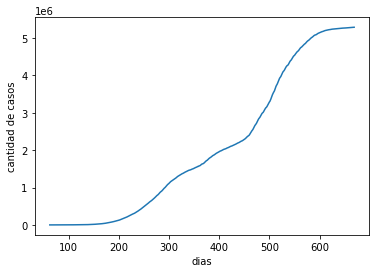

In [6]:
#seleccionamos Argentina
ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Observamos que en Argentina el primer caso de Covid no fue inmediatamente posterior al primer caso detectado en el mundo. Para determinar el día en que se detectó el primer caso en Arg primero vamos a filtrar por Pais, allí obtenemos los indices.

In [7]:
#paises[paises == 'Argentina']
#ind_arg[0]
ind_arg[:10]
# o podemos hacer esto
#np.where(paises=='Argentina')

array([4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534])

In [8]:
#confirmados[ind_arg]

In [9]:
#Transformamos el array a lista
lst = list(casos_arg)

In [10]:
# Buscamos el primer valor no nulo, sería el primer día con casos
#casos_arg[np.isfinite(casos_arg)][0]
lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]

1.0

In [11]:
# Buscamos el indice del primer elemento no nulo
lst.index(next(filter(lambda x: not np.isnan(x), lst)))

62

In [12]:
## entonces el primer caso corresponde al indice 4391
casos_arg[62:][:5]

4587    1.0
4588    1.0
4589    1.0
4590    2.0
4591    8.0
Name: total_cases, dtype: float64

Una vez obtenido el primer elemento no nulo, es decir cuando ocurre el primer caso, podemos saber cual es la fecha a partir de indice obtenido.

In [13]:
# primer caso de covid en Argentina
datos2.loc[4587].date

'2020-03-03'

El primer caso de Covid fue en Argentina fue detectado el 2020-03-03


Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

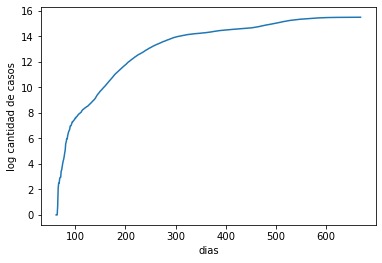

In [14]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

#### **b.2 Seleccionar la etapa de primer crecimiento exponencial de la curva** <a class="anchor" id="section_1_2_2"></a>
[Tabla de contenidos](#TOC)

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

In [15]:
# comenzamos desde el indice 62 que es cuando se detectó el primer caso en Argentina. id 4391
print(list(casos_arg[62:122][:10]))

[1.0, 1.0, 1.0, 2.0, 8.0, 12.0, 12.0, 17.0, 19.0, 19.0]


Text(0, 0.5, 'cantidad de casos')

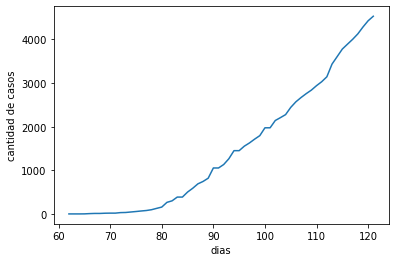

In [16]:
#Se filtra desde el primer día que hubo casos
casos_principio=casos_arg[62:122]
dias_principio=dias[62:122]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

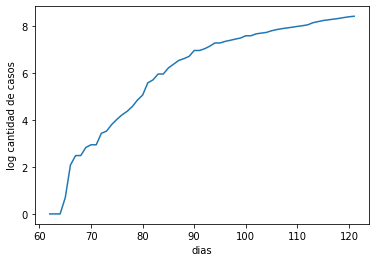

In [17]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Notar que los datos comienzan desde el día 62, que es el día en que se deectó el primer caso de covid en Argentina desde comenzada la pandemia en el mundo. Mejor nos quedamos con lo que sucede entre los días 93 y 107, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

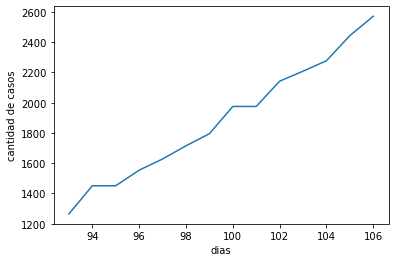

In [18]:
#casos_principio=casos_arg[31:55]
#dias_principio=dias[31:55]

casos_principio=casos_arg[93:107]
dias_principio=dias[93:107]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

#### **b.3 Extraer el k de crecimiento exponencial y comparar el modelo con los datos reales para distintos paises** <a class="anchor" id="section_1_2_3"></a>
[Tabla de contenidos](#TOC)

Text(0, 0.5, 'log cantidad de casos')

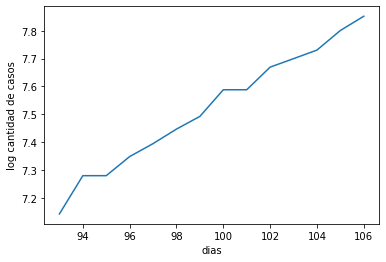

In [19]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [20]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [21]:
#ajustamos, popt[0] es nuestro "K" y popt[1] t0
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([  0.05065185, -49.02984924])

**popt :** Valores optimos para los parámetros, donde la suma del error cuadratico es minimizado. El primer elemento para nuestra función definida es el valor `k` y el segundo es `t0`

**pcov :** La covarianza estimada de popt. La diagonal provee la varianza del parametro estimado. Para computar el error, la desviación estandar de un parámetro hay usar perr = np.sqrt(np.diag(pcov)).

In [22]:
perr = np.sqrt(np.diag(pcov))
#float(perr)p
perr

array([1.39613439e-03, 4.13924674e+00])

In [23]:
#print("El intervalo de confianza para K es: {} - {}".format( round(perr[0],3), round(perr[1],3) ))

Veamos cómo se ajusta lo que obtuvimos a los datos reales

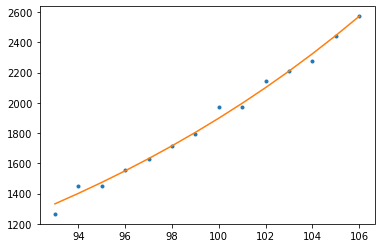

In [24]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

In [25]:
#print(list(dias_principio))

In [26]:
#print(list(casos_principio))

#### **b.4 Evolución de los casos de Covid en distintos paises)** <a class="anchor" id="section_1_2_4"></a>
[Tabla de contenidos](#TOC)

In [27]:
## Inicio de analisis

lista_paises = ['Argentina','Brazil','Chile','Colombia','France','Germany','Russia','Spain','United Kingdom','United States','India','China']
#lista_paises = ['Argentina','Brazil','Chile','Colombia']

Datos: Locations paises- Creamos una función que muestre cuando fue la aparición del primer caso y la evolución

100%|██████████| 12/12 [00:00<00:00, 43.23it/s]


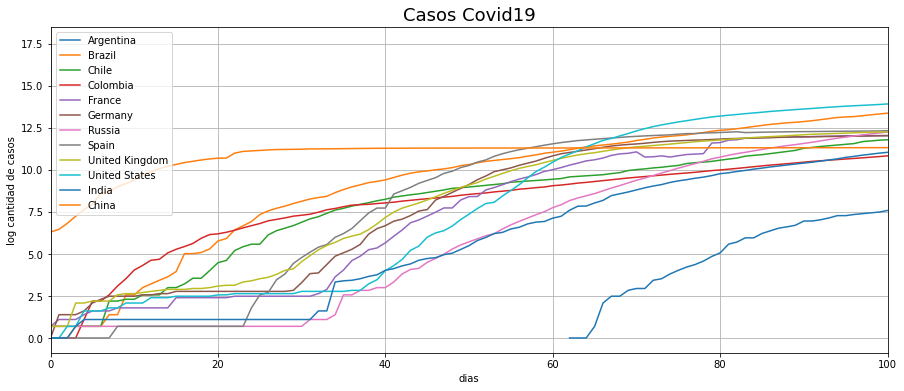

In [28]:
#armamos la figura para el gráfico
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Casos Covid19',fontsize=18, loc='center')
ax.set_xlim([0, 100])
ax.grid()

for x_pais in tqdm(lista_paises):
    #seleccionamos Argentina
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Argentina
    dia_start = datos2.date.loc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)    
    fig = plt.plot(dias,np.log(casos_xpais),label=x_pais)
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')
    #ax.set_xticklabels(models, rotation=0)
    ax.legend()

Se observa el crecimiento exponencial, en el caso de Argentina el primer caso fue 62 días posteriores al detectado el primer caso en el mundo. Para todos los paises se tomará 35 días después de detectado el primer caso, desde allí se puede observar un crecimiento continuo.

#### **b.5 Elegir diez países del norte (ahí empezó la pandemia)** <a class="anchor" id="section_1_2_5"></a>
[Tabla de contenidos](#TOC)

Definimos la lista de paises para entrenar nuestro modelo y obtener los mejores parámetros de `K` y `t0`

In [29]:
# lista de paises a evaluar, elegimos inicialmente 10 paices del emisferio Norte
#lista_paises = ['Denmark','Italy','Israel','Portugal','France','Germany','Russia','Spain','United Kingdom','United States','India','China']
lista_paises = ['Denmark','Italy','Israel','Portugal','France','Germany','Russia','Spain','United Kingdom','Belgium','India','Sweden']

#lista_paises = ['Argentina','Brazil','Chile','Colombia']
#lista_paises = ['France','Germany','Italy']

#### **b.6 Casos por millon de habitantes** <a class="anchor" id="section_1_2_6"></a>
[Tabla de contenidos](#TOC)

In [30]:
datos2_filter = datos2[datos2.location.isin(lista_paises)]
#datos2_filter.location.unique()

In [31]:
datos2_filter = datos2[datos2.location.isin(lista_paises)]
l_per_million_max = []
l_pais_per_million = []
x= datos2_filter.groupby(by='location')['total_cases_per_million'].agg(['max']).sort_values(by='max',ascending=False)
#lista_paises_ordenados = datos2_filter.groupby(by='location')['total_cases_per_million'].agg(['max']).sort_values(by='max',ascending=False).index

for pais in lista_paises:
    #print(pais)
    valor = x.loc[pais]['max']
    l_per_million_max.append(valor)
    l_pais_per_million.append(pais)
    print("{} casos por millon {}".format(pais,valor))

Denmark casos por millon 67212.576
Italy casos por millon 79048.615
Israel casos por millon 151022.961
Portugal casos por millon 107263.893
France casos por millon 107579.48
Germany casos por millon 54928.321
Russia casos por millon 57418.052
Spain casos por millon 107201.313
United Kingdom casos por millon 133423.648
Belgium casos por millon 116971.366
India casos por millon 24605.707
Sweden casos por millon 115304.495


In [32]:
#creamos las columnas del dataframe
df_paises_per_million = pd.DataFrame(columns=['pais','total_cases_per_million'])

#defimos las columnas
df_paises_per_million['pais'] = l_pais_per_million
df_paises_per_million['total_cases_per_million'] = l_per_million_max

#ordenamos y mostramos el dataframe
df_paises_per_million = df_paises_per_million.sort_values(['total_cases_per_million'], ascending=True)
df_paises_per_million.head(15)

,pais,total_cases_per_million
10,India,24605.707
5,Germany,54928.321
6,Russia,57418.052
0,Denmark,67212.576
1,Italy,79048.615
7,Spain,107201.313
3,Portugal,107263.893
4,France,107579.480
11,Sweden,115304.495
9,Belgium,116971.366


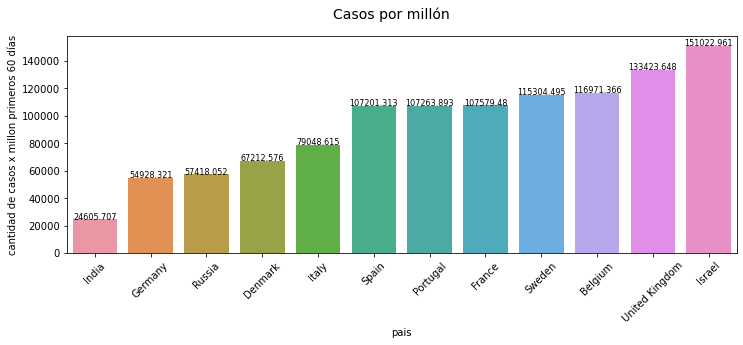

In [33]:
fig, axes = plt.subplots(1, figsize=(12,4))
fig.suptitle('Casos por millón', fontsize=14)
#axes = sns.barplot(data=datos2_filter, x ="location", y="total_cases_per_million", order=datos2_filter.groupby(by='location')['total_cases_per_million'].agg(['max']).sort_values(by='max',ascending=False).index)
axes = sns.barplot(data=df_paises_per_million, x ="pais", y="total_cases_per_million")
#axes.set_xlabel('dias')
axes.set_ylabel('cantidad de casos x millon primeros 60 días')
#axes.legend()
axes.set_xticklabels(df_paises_per_million['pais'], rotation=45)
#axes.legend()

for rect in axes.patches:
    axes.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 8)

plt.savefig("sort_bars_in_barplot_ascending_order_total_cases_per_million.png", dpi=100)
plt.show()

Los casos por millón de habitantes desde en que se detectó el primer caso en dicho pais hasta 60 días después. Es decir que se observa la ventada de 60 días desde la aparición desde el primer caso en el país observado. A continuación mostramos los casos desde comenzada la pandamia hasta la actualidad:

#### **b.7 Extraer el k de crecimiento exponencial y comparar el modelo con los datos reales para distintos paises** <a class="anchor" id="section_1_2_7"></a>
[Tabla de contenidos](#TOC)

La siguiente función calculará el `K` y `t0` para cada pais de una lista elegida (10 paises del emisferio norte donde comenzó la pandemia)

In [34]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
    C=np.exp(k*(t-t0))
    return C

#definimos función para calcular k para cada pais 
def calcular_k(lista_paises):
    '''
    Función para calcular el valor de k.
    
    Parameters
    ----------
    lista_paises : lista con los nombres de los 
        paises a evaluar.
         
    Returns
    -------
    valor k: lista
        con valor de k.
    '''
    #lista vacia para guardar los mejores valores de k obtenidos para cada modelo según el país.
    lista_k = []
    lista_t0 = []
    lista_casos_max = []
    lista_population = []

    l_per_million_max = []
    l_pais_per_million = []
    
    #armamos la figura para el gráfico
    #fig, ax = plt.subplots(figsize=(15,6))
    fig, axes = plt.subplots(2, figsize=(15, 12))
    fig.suptitle('Casos Covid19', fontsize=20)
    fig.tight_layout(pad=4.0)

    axes[0].set_title('Casos Covid19 Logaritmico',fontsize=14, loc='center')
    axes[0].set_xlim([0, 85])
    axes[0].grid()

    axes[1].set_title('Casos Covid19 Simulados',fontsize=14, loc='center')
    axes[1].set_xlim([0, 85])
    #axes[1].set_ylim([0, 200000])
    axes[1].grid()

    #color lineas gráfico
    marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))


    for x_pais in lista_paises:
        #seleccionamos Pais
        ind_xpais=np.where(paises==x_pais)
        ind_xpais=ind_xpais[0]
        ##poblacion x pais
        poblacion_xpais=int(population[0])
       
        #casos
        casos_xpais=confirmados[ind_xpais]
        dias=np.arange(0,len(casos_xpais))
        #Imputamos los nan con 0
        #casos_xpais.fillna(0, inplace=True)
    
        
        #Transformamos a lista
        lst = list(casos_xpais)
        # Buscamos el primer valor no nulo, sería el primer día con casos
        ##from numpy import nan
        #casos_arg[np.isfinite(casos_arg)][0]
        primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
        # Buscamos el indice del primer elemento no nulo
        ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
        # primer caso de covid en Argentina
        dia_start = datos2.date.loc[ind_x]
        print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
        ## Graficamos
        
        #color de la lineas
        color = next(ax._get_lines.prop_cycler)['color']
        
        #fig, ax = plt.subplots(figsize=(8,3))
        dias=np.arange(0,len(casos_xpais))
        #ax.set_xticklabels(models, rotation=0)    
        axes[0].plot(dias,np.log(casos_xpais),label=x_pais, color=color)
        axes[0].set_xlabel('dias')
        axes[0].set_ylabel('log cantidad de casos')
        #ax.set_xticklabels(models, rotation=0)
        axes[0].legend()
    
        ################# Estimamos K
        
        dia_desfase = 0
        ind_inicio = ind_x + dia_desfase
        ind_final = ind_inicio + dia_desfase + 60
        
        #dias=np.arange(0,len(casos_arg))
    
        #print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
        casos_principio=casos_xpais[ind_inicio:ind_final]
        dias_principio=dias[ind_inicio:ind_final]
        #print(list(dias_principio))    
        #print(list(casos_principio))

        #ajustamos, popt[0] es nuestro "K" y popt[1] t0
        popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
        #popt
    
        #Guardamos el valor de k y t0 en la lista:
        lista_k.append(popt[0])
        lista_t0.append(popt[1])
        lista_casos_max.append(casos_principio.max())
        lista_population.append(poblacion_xpais)
        
        # Ajustamos los datos con los valores de los parámetros obtenidos
        k=popt[0]
        t0=popt[1]
        #print("PARAMETRO K: ",k)    
        #print("PARAMETRO t0: ",t0)
        #print(dias_principio.size)
        #print(casos_principio.size)
        #print(casos_principio.min())
        #print(casos_principio.max())

        casos_simu=exponencial(dias_principio,k,t0)
        ## Graficamos las simulaciones

        axes[1].plot(dias_principio,casos_principio,'.', color=color)
        axes[1].plot(dias_principio,casos_simu,label=x_pais, color = color)
        axes[1].set_xlabel('dias')
        axes[1].set_ylabel('cantidad de casos')
        axes[1].legend()
        
        per_mill_max = datos2[datos2['location']==x_pais][ind_inicio:ind_final].total_cases_per_million.max()
        l_per_million_max.append(per_mill_max)
        l_pais_per_million.append(x_pais)
        
        
    return lista_k,lista_t0, lista_casos_max, lista_population,l_per_million_max,l_pais_per_million

Ejecutamos la función pasandole como argumento la lista de paises anteriormente definida:

En Denmark el/los primer/primeros 1.0 casos fue el día 2020-03-20 indice 25
En Italy el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
En Israel el/los primer/primeros 1.0 casos fue el día 2020-02-25 indice 1
En Portugal el/los primer/primeros 2.0 casos fue el día 2020-03-01 indice 6
En France el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
En Germany el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0
En Russia el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
En Spain el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0
En United Kingdom el/los primer/primeros 2.0 casos fue el día 2020-02-24 indice 0
En Belgium el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0
En India el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0
En Sweden el/los primer/primeros 1.0 casos fue el día 2020-02-24 indice 0


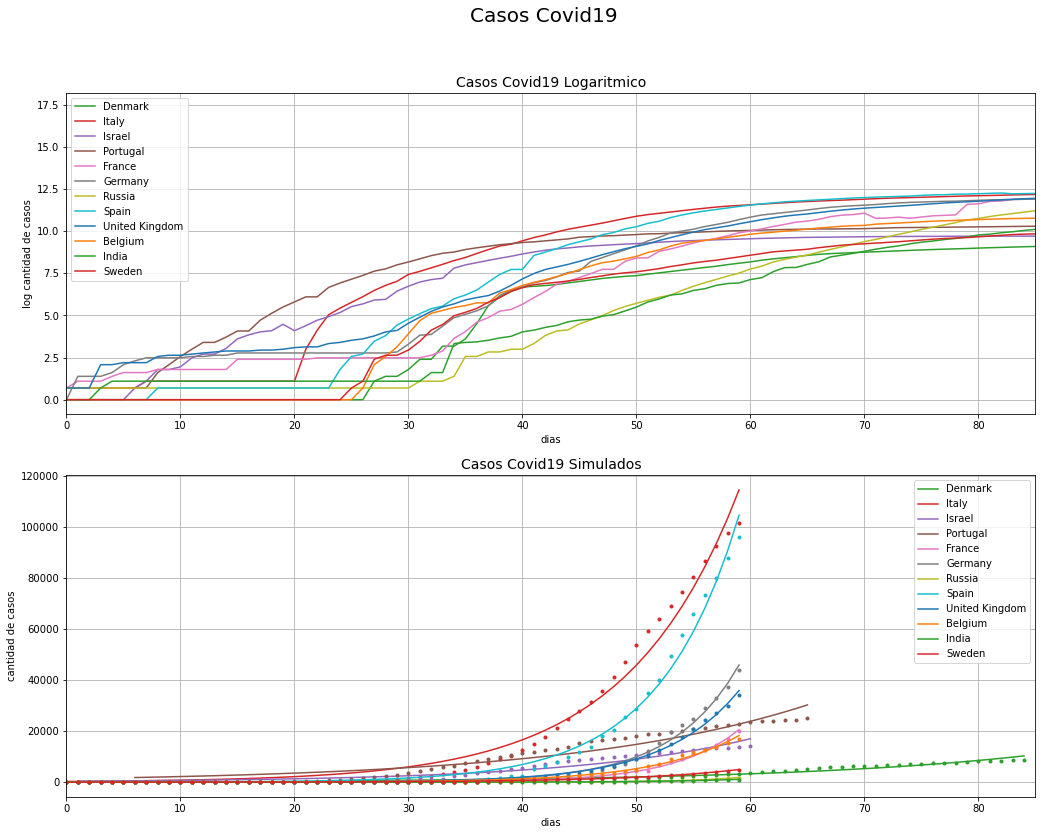

In [35]:
lista_k,lista_t0,lista_casos_max,lista_population,l_per_million_max,l_pais_per_million = calcular_k(lista_paises)
#print("Promedio de casos máximos en el primer periodo {}".format(np.array(lista_casos_max).flatten().mean() ))

In [36]:
mean_poblacion_simu = int(np.array(lista_population).flatten().mean())
print("Población media de lso paises elegidos {}".format(mean_poblacion_simu) )
#int(np.array(lista_population).flatten().mean())

Población media de lso paises elegidos 39835428


#### **b.8 Generar un intervalo de confianza para el valor de k midiéndolo para varios paises** <a class="anchor" id="section_1_2_8"></a>
[Tabla de contenidos](#TOC)

Graficamos la distribución de K para los módelos obenidos anteriormente para cada pais.

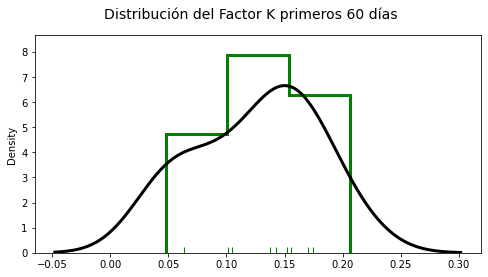

In [37]:
fig, axes = plt.subplots(1, figsize=(8,4))
fig.suptitle('Distribución del Factor K primeros 60 días', fontsize=14)
axes = sns.distplot(lista_k, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

#### Intervalo de confianza basado en percentiles
Mediante bootstrapping, se simula la variabilidad esperada en el estadístico, en este caso la media, debido únicamente al muestreo aleatorio.

In [38]:
def calcular_estadistico(x):
    '''
    Función para calcular el estadístico de interés.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    estadistico = np.mean(x)
    
    return(estadistico)


def bootstraping(x, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples muestras generadas
    mediante muestreo repetido con reposición (bootstrapping).
    
    Parameters
    ----------
    x : numpy array 
        valores de la muestra.
 
    fun_estadistico : funcion
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número iteraciones (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada muestra de bootstrapping.
    '''
    
    n = len(x)
    #Return a new array of given shape and type, filled with fill_value. Array con con shape 9999 y todos los valores en nan
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)
        
    return dist_boot

Calcular el estadístico, en este caso la media

In [39]:
# Convertir lista a array
datos = np.array(lista_k)

In [40]:
dist_boot = bootstraping(
                x = datos,
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:00<00:00, 16558.35it/s]


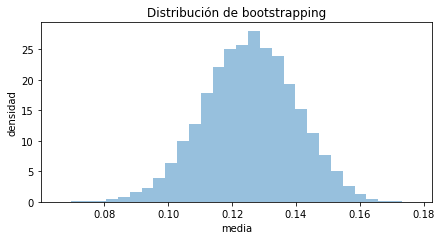

In [41]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,3.3))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('media')
ax.set_ylabel('densidad');

La dispersión de la distribución obtenida por bootstrapping es una aproximación del error estándar esperado debido a proceso de muestreo. Por esta razón, pueden emplearse sus percentiles para calcular intervalos de confianza. 

Ahora generemos el intervalo de confianza.  Primero hay que elegir $\alpha$, el error que estamos dispuestas/os a cometer. En este caso tomaremos $\alpha=0.05$, que implica que toleraremos hasta un 5% de error.

Una vez establecido alpha, podemos armar el intervalo de confianza para saber con un 95% un intervalo donde se encuentra el promedio $\mu$ de toda la población, usando una submuestra de esta. 

In [42]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo de confianza de K basado en percentiles es:')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo de confianza de K basado en percentiles es:
-------------------------------
[0.09644468 0.15301968]


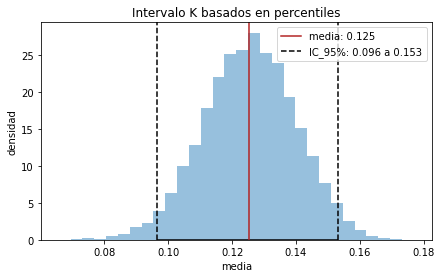

In [43]:
# Gráfico intervalo de confianza del 95% para K, aceptando un error de 5%
# ==============================================================================
media_obs = datos.mean()
media_obs = "{:.3f}".format(datos.mean())
media_obs = "media: " + media_obs

int_obs_izq = list(cuantiles)
int_obs_izq = "{:.3f}".format(cuantiles[0])
int_obs_der = "{:.3f}".format(cuantiles[1])

IC_95 = "IC_95%: " + int_obs_izq +" a "+ int_obs_der

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
#ax.axvline(x=datos.mean(), color='firebrick', label='media observada')
ax.axvline(x=datos.mean(), color='firebrick', label=media_obs)

#ax.axvline(x=cuantiles[0], color='black', linestyle='--', label=IC 95%)
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label=IC_95)
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo K basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

### **c. Criterio de elección de los paises** <a class="anchor" id="section_1_3"></a>
[Tabla de contenidos](#TOC)

El criterio de elección de los paises empleados para obtener el intervalo de confianza fue en elegir aquellos paises del emisferio del norte donde comenzó la pandemia, es decir en el primer periodo (60 días) aquellos que fueron más relevantes a nivel casos/muertes y/o más comentados según medios de comunicación.

### **d. Evaluando modelo**  <a class="anchor" id="section_1_4"></a>
[Tabla de contenidos](#TOC)

Redifinimos la función exponencial con los parámetros obtenidos de `K` y `t0`, luego probamos con datos reales de otros países

#### **d.1 Función predecir para simular curvas** <a class="anchor" id="section_1_4_1"></a>
[Tabla de contenidos](#TOC)

In [44]:
k=float("{:.3f}".format(datos.mean()))
t0=np.median(lista_t0)
#print(k)
#print(t0)

In [45]:
# Definimos la función para predecir2 la curva de contagios para x pais según el valor de k obtenido.

#def predecir(lista_paises,k,t0):
def predecir2(x_pais,k,t0):
    '''
    Función para calcular el valor de k.
    
    Parameters
    ----------
    lista_paises : lista con los nombres de los 
        paises a evaluar.
         
    Returns
    -------
    valor k: lista
        con valor de k.
    '''    

#    for x_pais in lista_paises:
    #seleccionamos Pais
    #print("Pais seleccionado: {}".format(x_pais))
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    dias=np.arange(0,len(casos_xpais))
    #Imputamos los nan con 0
    #casos_xpais.fillna(0, inplace=True)
    
        #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Pais_X
    dia_start = datos2.date.loc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    dias=np.arange(0,len(casos_xpais))
    ############### indices inicio y final
    ind_inicio = ind_x
    #ind_inicio = 0
    ind_final = ind_inicio + 60
    #ind_final = ind_inicio 
        
        ################# Estimamos K

    dias_x=np.arange(ind_x,ind_final)
    #dias_x=np.arange(0,60)

    #print("----dias_x para simulacion-----")
    #print(list(dias_x))
    
    #print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
    casos_principio=casos_xpais[ind_inicio:ind_final]
    dias_principio=dias[ind_inicio:ind_final]
    #print("----dias_principio casos reales------")
    #print(list(dias_principio)) 
    #print("------casos_principio reales-----")
    #print(list(casos_principio.astype(int)))

    #ajustamos, popt[0] es nuestro "K" y popt[1] t0
    #popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
    #popt
    
    #Guardamos el valor de k en la lista:
    #lista_k.append(popt[0])

    # Ajustamos los datos con los valores de los parámetros obtenidos
    #k=popt[0]
    #t0=popt[1]
    #print("PARAMETRO K: ",k)    
    #print("PARAMETRO t0: ",t0)
    #print(dias_principio.size)
    #print(casos_principio.size)
    #print(dias_x.size)
    casos_simu=exponencial(dias_x,k,t0)
    #print(casos_simu.size)
    #print("-----casos_simu------")
    #print(list(casos_simu.astype(np.int)))
    
    # Prediccion usando el intervalo de confianza k
    casos_simu_izq=exponencial(dias_x,float(int_obs_izq),t0)
    casos_simu_der=exponencial(dias_x,float(int_obs_der),t0)
    
   
    ## Graficamos las simulaciones
    #label_simu=x_pais + " simulados"
    #label_real=x_pais + " reales"

    #color de la lineas
    color = next(ax._get_lines.prop_cycler)['color']
#    axes.plot(dias_principio,casos_principio,label=label_real, color=color)
    #axes.plot(dias_principio,casos_simu,label=x_pais, color = color)
    #axes.plot(0,dias,'.', color=color)
#    axes.plot(dias_x,casos_simu,'.',label=label_simu, color = color)
    #axes.set_xlabel('das')
    #axes.set_ylabel('cantidad de casos')
#    axes.legend()
#    plt.xlim([ind_inicio,ind_final])
        
    return dias_principio,casos_principio,dias_x,casos_simu,color,casos_simu_izq,casos_simu_der

#### **d.2 Simulacion** <a class="anchor" id="section_1_4_2"></a>
[Tabla de contenidos](#TOC)

Pasamos la lista de paises a evaluar

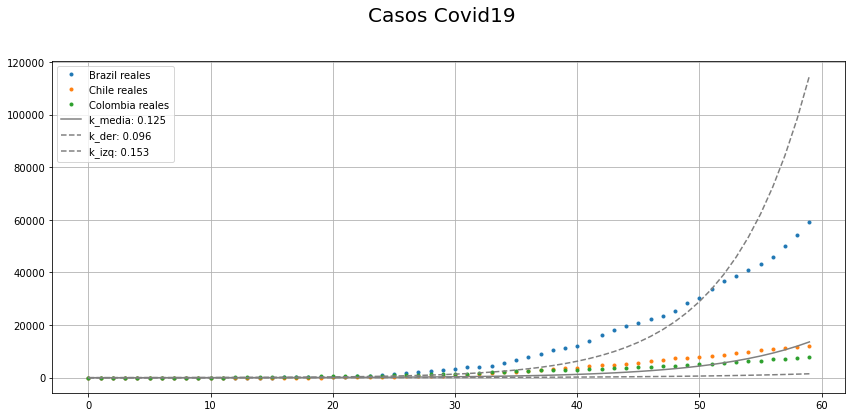

In [46]:
#lista_paises = ['Argentina','Brazil','Chile','Colombia']
lista_paises = ['Brazil','Chile','Colombia']

#Lista error
lista_mae = []
lista_rmse = []
lista_mse = []

#armamos la figura para el gráfico
#fig, ax = plt.subplots(figsize=(15,6))
fig, axes = plt.subplots(1, figsize=(12, 6))
fig.suptitle('Casos Covid19', fontsize=20)
fig.tight_layout(pad=2.0)

#axes.set_title('Casos Covid19 Simulados {}'.format(x_pais),fontsize=14, loc='center')
#axes.set_xlim([0, 120])
axes.grid()

#color lineas gráfico
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))

for x_pais in lista_paises:
    #dias_principio,casos_principio,dias_x,casos_simu,casos_simu_izq,casos_simu_der,color = predecir2(x_pais,k,t0)
    dias_principio,casos_principio,dias_x,casos_simu,color,casos_simu_izq,casos_simu_der = predecir2(x_pais,k,t0)
 
    label_simu = "{} simulados".format(x_pais)
    label_real = "{} reales".format(x_pais)  
    
    #print(color)
    axes.plot(dias_principio,casos_principio,'.',label=label_real, color=color)
    #plt.xlim([ind_inicio,ind_final])
    #print(lista)
    #print("----dias_principio casos reales------")
    #print(list(dias_principio)) 
    #print("------casos_principio reales-----")
    #print(list(casos_principio.astype(int)))
     
    #### Calculamos el error  
    mae =  int(metrics.mean_absolute_error(casos_principio, casos_simu))
    mse = int(metrics.mean_squared_error(casos_principio, casos_simu))
    rmse = int(np.sqrt(metrics.mean_squared_error(casos_principio, casos_simu)))
    
    #print('Mean Absolute Error lista_mae:', mae)  
    #print('Mean Squared Error, lista_mse :', mse)  
    #print('Root Mean Squared Error, lista_rmse:', rmse)
    
    # guardamos los datos en una lista   
    lista_mae.append(mae)
    lista_mse.append(mse)
    lista_rmse.append(rmse)
    
    # 
    #print("lista mse",lista_mse)
    
#label_k_media = "k_media: ",float("{:.3f}".format(datos.mean()))
#label_k_izq = "k_der: ", float(int_obs_izq)
#label_k_der = "k_izq: ", float(int_obs_der)

label_k_media = "k_media: {}".format(round(datos.mean(),3))
label_k_izq = "k_der: {}".format(float(int_obs_izq))
label_k_der = "k_izq: {}".format(float(int_obs_der))

axes.plot(dias_x,casos_simu,label=label_k_media, color = 'grey')
axes.plot(dias_x,casos_simu_izq,label=label_k_izq, linestyle='--', color = 'grey')
axes.plot(dias_x,casos_simu_der,label=label_k_der, linestyle='--', color = 'grey')

#sns.regplot(dias_x,casos_simu,label="modelo", color = 'grey',ci=50)

#axes.plot(dias_x,casos_simu,'.',label=label_simu, color = 'red')
axes.legend()
plt.show()

Aquí se observa como se despega la curva de contagíos predicha con la real utilizando el modelo entrenado con datos de los paises donde comenzó la epidemia. 

Con los paises elegidos para entrenar nuestro modelo (obtener los parámetros k y t0) el primer caso de Covid fue detectado el 22 de Febrero.

- Argentina: se detectó el primer caso el 2020-04-26, es decir 62 días después de detectado el primer caso en el mundo. La cuarentena comenzó el 20 de marzo tomando medidas muy estrictas.

- Brasil: no se tomaron medidas de resticciones, con lo cual el modelo aproxima a la curva simulada.

- Chile: la cuarentena comenzó el 26 de Marzo, el primer caso fue el 2020-02-24, con lo cual al principio la curva simulada se asemeja al de los casos reales en los paises del emisferio Norte seleccionados, luego se produce una separación por las medidas de cuarentena tomadas.

- Colombia: la cuarentena comenzó el 25 de Marzo, el primer caso fue el 2020-02-24

#### **d.3 Evaluación del modelo por pais (mae, mse y rmse)** <a class="anchor" id="section_1_4_3"></a>
[Tabla de contenidos](#TOC)

Creamos una dataframe con los datos reales y los predicho por el modelo para un momento x.

In [47]:
#creamos las columnas del dataframe
df_paises_error = pd.DataFrame(columns=['pais','mae', 'mse','rmse'])

In [48]:
# llenamos con los datos de las listas obtenidas anteriormente
df_paises_error['pais'] = lista_paises
df_paises_error['mae'] = lista_mae
df_paises_error['mse'] = lista_mse
df_paises_error['rmse'] = lista_rmse

In [49]:
#ordenamos y mostramos el dataframe
df_paises_error = df_paises_error.sort_values(['rmse'], ascending=True)
df_paises_error.head(5)

,pais,mae,mse,rmse
2,Colombia,1003,2157247,1468
1,Chile,1195,3244582,1801
0,Brazil,9994,271415118,16474


Graficamos para comparar los modelos

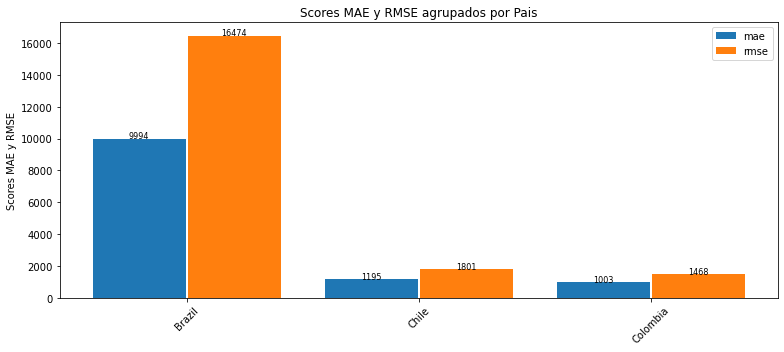

In [50]:
#numero de pares de barras a crear
x = np.arange(len(lista_paises))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(11,5))

#bar_mae = ax.bar(x - width, list(map(int, lista_mae)), width=width, label='mae')
##bar_mse = ax.bar(x , np.log(list(map(int, lista_mse))), width=width, label='mse')
#bar_rmse = ax.bar(x + width, list(map(int, lista_rmse)), width=width, label='rmse')
bar_mae = ax.bar(x - width/1.95, list(map(int, lista_mae)), width=width, label='mae')
bar_rmse = ax.bar(x + width/1.95, list(map(int, lista_rmse)), width=width, label='rmse')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores MAE y RMSE')
ax.set_title('Scores MAE y RMSE agrupados por Pais')
ax.set_xticks(x)
ax.set_xticklabels(lista_paises, rotation=45)
ax.legend()

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 8)

#plt.axhline(y=54423, color='r', linestyle='--')

fig.tight_layout()

plt.show()

In [51]:
#flatten() function return a copy of the array collapsed into one dimension
#df = pd.DataFrame({'Actual': np.array(casos_principio).flatten(), 'Predicted': casos_simu.flatten()})
#df.head()

#### **d.4 Evaluación de los casos a nivel mundial** <a class="anchor" id="section_1_4_4"></a>
[Tabla de contenidos](#TOC)

Comparamos el modelo obtenido con la evolución de casos de covid-19 a nivel mundial:

In [52]:
df = datos_orig

In [53]:
#Filtramos los casos mundiales
df = df[df['location'] == 'World']

In [54]:
#poblacion mundial
poblacion_mundial = int(df.population[125123])
poblacion_mundial

7874965730

In [55]:
# promedio de la poblacion para el fiteo
mean_poblacion_simu

39835428

In [56]:
## relacion entre poblacion total y la del modelo
factor_correccion = poblacion_mundial / mean_poblacion_simu
factor_correccion

197.6874888855217

In [57]:
fechas = []
contagios_mundiales = []

for i in tqdm(df.date.unique()):
  contagios = df.loc[df['date'] == i,['total_cases']].sum()
  contagios_mundiales.append(int(contagios))
  fechas.append(i)

100%|██████████| 649/649 [00:01<00:00, 364.42it/s]


In [58]:
#contagios_mundiales = pd.DataFrame(contagios_mundiales, columns=['total_cases'])
#contagios_mundiales.iloc[3]

In [59]:
# Creamos el dataframe con los datos anteriormente generados
d = {'date': fechas, 'total_cases': contagios_mundiales}
df_casos_mundo = pd.DataFrame(d)
df_casos_mundo.date = pd.to_datetime(df_casos_mundo.date)
df_casos_mundo.set_index(df_casos_mundo.date, inplace = True)
df_casos_mundo.drop(columns = ["date"], inplace = True)
df_casos_mundo.sort_index(inplace = True)

In [60]:
# Dia en que se detecto el primer caso en el mundo, 2020-01-22     557 casos
df_casos_mundo['total_cases'][0:5]

date
2020-01-22     557
2020-01-23     655
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
Name: total_cases, dtype: int64

In [61]:
# Reseteamos el indice, cambiamos el indice date por un indice númerico consecutivo incremental
df_casos_mundo_dias = df_casos_mundo.reset_index(drop = True, inplace=False)
#df_casos_mundo_dias[0:3]

Definimos periodo de observación, como el modelo fue creado con una función exponencial con datos al principio de la pandemia, vamos a analizar mismo perioro para contrastar lo simulado (predicho), con los casos reales.

In [62]:
#definimos periodo analizar
ind_start = 0
ind_stop = 60
#ind_start = 0
#ind_stop = 700

# predecimos
dias_x=np.arange(ind_start,ind_stop)
casos_simu=exponencial(dias_x,k,t0)

#filtramos los casos reales para ese periodo
df_casos_mundo_dias_x =  df_casos_mundo_dias[ind_start:ind_stop]
#df_casos_mundo_dias_x


Gráficamos los casos reales a nivel mundial (acumulados) y en un segundo gráfico comparamos lo predicho con lo real.

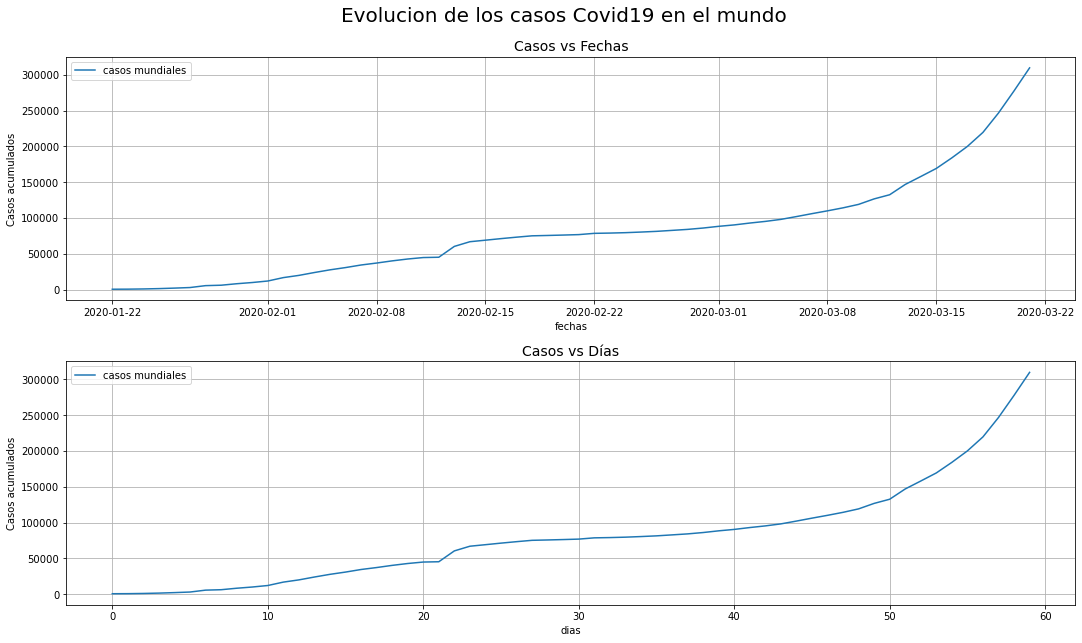

In [63]:
#armamos la figura para el gráfico
    #fig, ax = plt.subplots(figsize=(15,6))
fig, axes = plt.subplots(2, figsize=(15, 9))
fig.suptitle('Evolucion de los casos Covid19 en el mundo', fontsize=20)
#fig.tight_layout(pad=4.0)
fig.tight_layout(pad=2, w_pad=0.5, h_pad=4.0)

#titulos
axes[0].set_title('Casos vs Fechas',fontsize=14, loc='center')
#axes[0].set_xlim([0, 85])
axes[0].grid()

axes[1].set_title('Casos vs Días',fontsize=14, loc='center')
#axes[1].set_xlim([0, 85])
#axes[1].set_ylim([0, 500000])
axes[1].grid()


## Graficamos Casos vs Fechas
#ax.set_xticklabels(models, rotation=0)    
axes[0].plot(df_casos_mundo['total_cases'][ind_start:ind_stop],label="casos mundiales")
axes[0].set_xlabel('fechas')
axes[0].set_ylabel('Casos acumulados')
#ax.set_xticklabels(models, rotation=0)
axes[0].legend()

## Graficamos Casos vs Dias
#ax.set_xticklabels(models, rotation=0)    
#axes[1].plot(df_casos_mundo_dias['total_cases'],label="casos mundiales")
axes[1].plot(df_casos_mundo_dias_x,label="casos mundiales")
axes[1].set_xlabel('dias')
axes[1].set_ylabel('Casos acumulados')
##ax.set_xticklabels(models, rotation=0)
#axes[1].plot(casos_simu,label="casos simulados")
#axes[1].plot(casos_simu_izq,label="casos simulados izq",color = 'grey')
#axes[1].plot(casos_simu_der,label="casos simulados der",color = 'grey')

axes[1].legend()

plt.show()

#### **d.5 Evaluación del modelo a nivel mundial (mae, mse y rmse)** <a class="anchor" id="section_1_4_5"></a>
[Tabla de contenidos](#TOC)

Comparamos lo predicho por el modelo y los casos reales. Para ellos lo escalamos, empleamos el `factor_correccion` anteriormente creado, esto se realizo debido que el modelo fue creado para la población de la selección de un grupo de paises y no para la cantidad de habitantes mundiales. Además para realizar una simple comparación, como se muestra a continuacion se lo lleva a una escala logaritmica.

In [64]:
#flatten() function return a copy of the array collapsed into one dimension
#df = pd.DataFrame({'Actual': np.array(df_casos_mundo_dias_x).flatten(), 'Predicted': casos_simu.flatten()})
df = pd.DataFrame({'Actual': np.array(np.log(df_casos_mundo_dias_x)).flatten(), 'Predicted': np.log(casos_simu*factor_correccion).flatten()})

df.head(5)

,Actual,Predicted
0,6.322565,7.429635
1,6.484635,7.554635
2,6.846943,7.679635
3,7.268223,7.804635
4,7.658228,7.929635


In [65]:
#### Calculamos el error pero con los datos aplicando logaritmo para escalarlos
print('Mean Absolute Error:', int(metrics.mean_absolute_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion))  ) )  
print('Mean Squared Error:', int(metrics.mean_squared_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion)) ) )  
print('Root Mean Squared Error:', int(np.sqrt(metrics.mean_squared_error(np.log(df_casos_mundo_dias_x), np.log(casos_simu*factor_correccion)) )))

Mean Absolute Error: 1
Mean Squared Error: 1
Root Mean Squared Error: 1


Los casos al principio que se utilizaron en el modelo para fittear fue en promedio de 1, los casos reales parte de 557 casos. Con lo cual podemos escalar los datos con una realación de 1:557

In [66]:
#### Calculamos el error pero con los datos aplicando logaritmo para escalarlos
print('Mean Absolute Error:', int(metrics.mean_absolute_error(df_casos_mundo_dias_x, casos_simu*factor_correccion))  ) 
print('Mean Squared Error:', int(metrics.mean_squared_error(df_casos_mundo_dias_x, casos_simu*factor_correccion) ) )  
print('Root Mean Squared Error:', int(np.sqrt(metrics.mean_squared_error(df_casos_mundo_dias_x,casos_simu*factor_correccion)) ))

Mean Absolute Error: 315114
Mean Squared Error: 412408918178
Root Mean Squared Error: 642190


#### **d.6 Graficos para interpretacion de los datos** <a class="anchor" id="section_1_4_6"></a>
[Tabla de contenidos](#TOC)

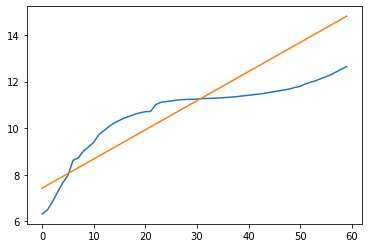

In [67]:
plt.plot(np.log(df_casos_mundo_dias_x))
plt.plot(np.log(casos_simu*factor_correccion))
plt.show()

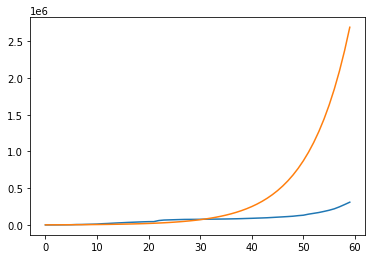

In [68]:
plt.plot(df_casos_mundo_dias_x)
plt.plot(casos_simu*factor_correccion)
plt.show()

Una Mejor aproximación, sería entrenar el modelo con los datos de casos por millon de habitantes `total_cases_per_million`, así ahí trabajar con un modelo de proporciones. Se observa que el comporamiento hasta el día 33 el modelo aproxima bien pero luego hay un desfasaje en su comportamiento, esto puede ser debido a la diferencia entre los paises tomados para realizar el modelo y el resto del mundo, algunos paises tuvieron comportamiento muy distinto a estos, por ejemplo China, el pais con más habitantes logró aplanar su curva rapidamente, es decir que la función que la describe no es exponencial.

### **Evaluando estrategias** <a class="anchor" id="chapter2"></a>

#### **f. Elección de politica pública e indicadores** <a class="anchor" id="section_2_1"></a>
[Tabla de contenidos](#TOC)

### Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

### Comenzamos

https://github.com/owid/covid-19-data/tree/master/public/data


#### **f.1 Se elige política: cuarentena** <a class="anchor" id="section_2_1_1"></a>
[Tabla de contenidos](#TOC)

1 - Vamos a clasificar las poblaciones que realizaron cuarentena y las que no. La metrica Policy responses tenemos datos de 186/233 paises, con lo cual comenzaremos a filtrar cuales son esos paises.


Variable es `stringency_index` Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)

In [69]:
df = datos_orig.copy()

In [70]:
df.location.unique().size

233

In [71]:
#df.fillna(0,inplace=True)
#df.loc[df['stringency_index'] != 0, 'cuarentena'] = '1'
#df.loc[df['stringency_index'] == 0, 'cuarentena'] = '0' 

In [72]:
#df[df['location'] == "Argentina"].stringency_index[0:100].isnull().sum()
#df[df['location'] == "Argentina"].stringency_index.isnull().sum()

Top de paises que más días realizaron cuarentena (cada día tiene un indicador de la cuarentena aplicada, siendo 0 el nivel más bajo de restricción y 100 la más estricta según una escala establecida por 9 preguntas).

In [73]:
#df_cuarentena = df.groupby('location')['stringency_index'].agg('count').sort_values(ascending=False) 
#df_cuarentena
#df_cuarentena_sum = df.groupby('location')['stringency_index'].agg(np.sum)
#df_cuarentena_sum

In [74]:
#df1 = df.groupby(by='location').agg({'stringency_index': ['sum','count']}).reset_index().rename(columns={'sum':'Suma'} )

### **g. Implpementación de cuarentena**  <a class="anchor" id="section_2_2"></a>
[Tabla de contenidos](#TOC)

#### **g.1 Ranking cuarentena por paises** <a class="anchor" id="section_2_2_1"></a>
[Tabla de contenidos](#TOC)

In [75]:
df_cuarentena = df.groupby(by='location')['stringency_index'].agg(['count','sum','median','mean']).sort_values(by='count',ascending=False)
#df_cuarentena['median']
df_cuarentena.shape

(233, 4)

In [76]:
#paises que no hicieron cuarentena
#df_sin_cuerentena = df_cuarentena.to_frame()
df_sin_cuarentena = df_cuarentena[df_cuarentena['count'].sort_values(ascending=True) == 0]

df_sin_cuarentena = pd.DataFrame(df_sin_cuarentena)
df_sin_cuarentena['pais'] = df_sin_cuarentena.index
#df_sin_cuerentena.drop(['B', 'C'], axis=1)
df_sin_cuarentena = df_sin_cuarentena['pais']
#df_sin_cuerentena.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_sin_cuarentena.reset_index(drop=True, inplace=True)
df_sin_cuarentena = pd.DataFrame(df_sin_cuarentena)
df_sin_cuarentena = df_sin_cuarentena[['pais']].sort_values(['pais'], ascending=True)
print("a primera vista hay {} paises que no realizaron cuarentena".format(df_sin_cuarentena.size))
df_sin_cuarentena.head(10)

a primera vista hay 51 paises que no realizaron cuarentena


,pais
26,Africa
4,Anguilla
22,Antigua and Barbuda
49,Armenia
21,Asia
24,Bonaire Sint Eustatius and Saba
23,British Virgin Islands
28,Cayman Islands
42,Comoros
45,Cook Islands


Filtramos los continentes y demás que no corresponden con paises.

In [77]:
list_quitar = ['World','South America','Oceania','European Union','Europe','Asia','Africa']

In [78]:
df_sin_cuarentena = df_sin_cuarentena[~df_sin_cuarentena.isin(list_quitar)]

In [79]:
#Dropeamos los nulos y reseteamos el indice
df_sin_cuarentena.dropna(inplace=True)
df_sin_cuarentena.reset_index(drop=True, inplace=True)
print("Quitando los datos que no corresponden hay {} paises que no realizaron cuarentena".format(df_sin_cuarentena.size))
df_sin_cuarentena.head()

Quitando los datos que no corresponden hay 44 paises que no realizaron cuarentena


,pais
0,Anguilla
1,Antigua and Barbuda
2,Armenia
3,Bonaire Sint Eustatius and Saba
4,British Virgin Islands


In [80]:
# lista de paises sin cuarentena elegidos 
#list_pais_sin_cuarentena = df_sin_cuarentena['pais']
#list_pais_sin_cuarentena

Ahora vamos a ver los paises que si realizaron cuarentena, también filtramos los que no corresponden. 

In [81]:
# Definir el top de paises a filtrar
top_n = 20

In [82]:
df_cuarentena = pd.DataFrame({'pais': df_cuarentena.index,
                                        'dias_cuarentena': df_cuarentena['count'].values,
                                        'acum_restriccion': df_cuarentena['sum'].values,
                                        'mean_restriccion': df_cuarentena['mean'].values,
                                        'median_restriccion': df_cuarentena['median'].values
                                 })

# ordenamos los paises con la cuarentena más larga
#df_cuarentena = df_cuarentena.sort_values(by='dias_cuarentena',ascending=False)[0:top_n]

In [83]:
#filtramos los que no correspondan, los de la lista lista_quitar
df_cuarentena = df_cuarentena[~df_cuarentena.pais.isin(list_quitar)]

In [84]:
# mostramos el top n
df_cuarentena[0:top_n]

,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
0,Argentina,664,48218.06,72.617560,79.170
1,Peru,656,46099.07,70.272973,75.930
2,Thailand,654,33124.13,50.648517,52.780
3,Mexico,651,35881.29,55.117189,67.130
4,United States,648,38235.11,59.004799,63.425
5,South Korea,644,34072.42,52.907484,53.240
6,Hong Kong,642,40154.84,62.546480,65.740
7,Taiwan,642,21663.93,33.744439,25.000
8,Finland,641,27894.43,43.517051,43.980
9,Japan,641,26463.28,41.284368,45.370


In [85]:
df_cuarentena.pais.shape

(226,)

Calculamos los estadísticos

In [86]:
df_cuarentena.describe()

,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
count,226.000000,226.000000,182.000000,182.000000
mean,468.517699,26517.452301,56.004154,55.456538
std,242.816075,15520.682165,12.893943,14.999112
min,0.000000,0.000000,11.026462,8.330000
25%,554.750000,15405.427500,48.594756,45.602500
50%,588.500000,31881.410000,57.275461,56.480000
75%,607.750000,38268.995000,65.024706,67.130000
max,664.000000,50203.710000,85.091034,86.110000


#### **g.2 Distribución de los días de cuarentena y su severidad.** <a class="anchor" id="section_2_2_2"></a>
[Tabla de contenidos](#TOC)

Graficamos la distribución de los días de cuarentena y su severidad. Se analiza todo el periodo de tiempo del dataset.

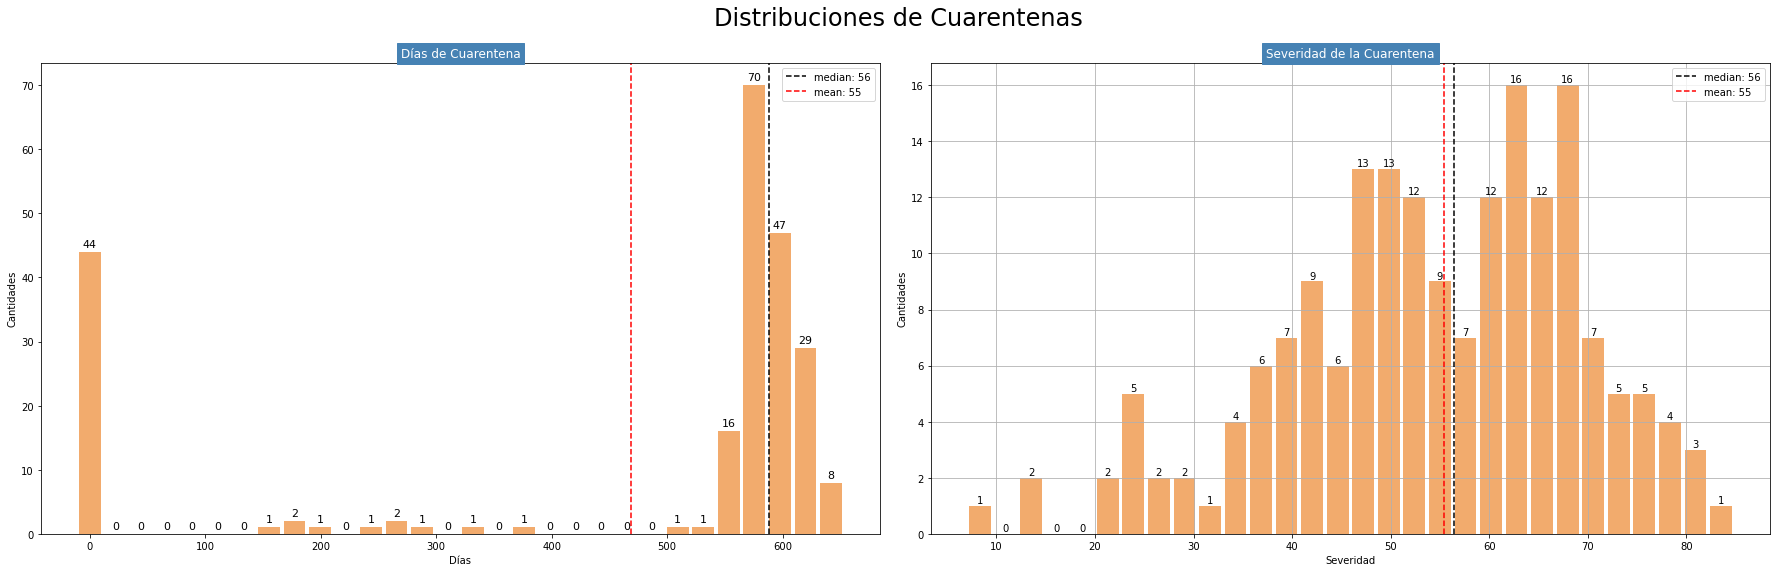

In [87]:
#intervalos = range(int(min(df_cuarentena['acum_restriccion'])), int(max(df_cuarentena['acum_restriccion'])) + 2) #calculamos los extremos de los intervalos
intervalo1 = 30
intervalo2 = 30

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Distribuciones de Cuarentenas', fontsize=24)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Días de Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=df_cuarentena['dias_cuarentena'], bins=intervalo1, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Días")
axes[0].set_ylabel("Cantidades")
#axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers
axes[0].axvline(x=df_cuarentena['dias_cuarentena'].median(), color='black', linestyle='--', label=label_median)
axes[0].axvline(x=df_cuarentena['dias_cuarentena'].mean(), color='red', linestyle='--', label=label_mean)
axes[0].legend()

count=0
for rect in axes[0].patches:
    count +=1
    if count <= intervalo1:  
        # prints the quit message
        #print(quit)
        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

#Grafico 1
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

axes[1].set_title("Severidad de la Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=df_cuarentena['median_restriccion'], bins=intervalo2, color='#F2AB6D', rwidth=0.85, align='left')

#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Severidad")
axes[1].set_ylabel("Cantidades")
#axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers
axes[1].axvline(x=df_cuarentena['median_restriccion'].median(), color='black', linestyle='--', label=label_median)
axes[1].axvline(x=df_cuarentena['median_restriccion'].mean(), color='red', linestyle='--', label=label_mean)

axes[1].legend()

count=0
for rect in axes[1].patches:
    count +=1
    if count <= intervalo2:  
        #axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 10)
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.1,int(rect.get_height()),horizontalalignment='center', fontsize = 10)
plt.show()


#### **g.3 Boxplot: distribución de la severidad de la cuarentena por pais.** <a class="anchor" id="section_2_2_3"></a>
[Tabla de contenidos](#TOC)

Realizamos un Boxplot para ver la distribución de las cuarentenas con respecto a la severidad de las medidas tomadas. Se eligen el top 20 de los paises con las cuarentenas más largas.

In [88]:
#list_top_pais = ['Argentina', 'Peru', 'Thailand', 'Mexico', 'United States', 'South Korea', 'Hong Kong', 'Taiwan', 'Finland', 'Japan', 'Vietnam', 'Singapore', 'Nepal', 'Italy', 'France', 'United Kingdom', 'Denmark', 'Cambodia', 'China', 'Canada']
list_top_pais = list(df_cuarentena['pais'][0:top_n])
#len(list_top_pais)
df_top = df.loc[df['location'].isin(list_top_pais)]
#len(df_top.location.unique())

In [89]:
# ordenamos los paises con la cuarentena más larga
df_order = df_cuarentena.sort_values(by='dias_cuarentena',ascending=False)[0:top_n].reset_index()
#df_order['pais']

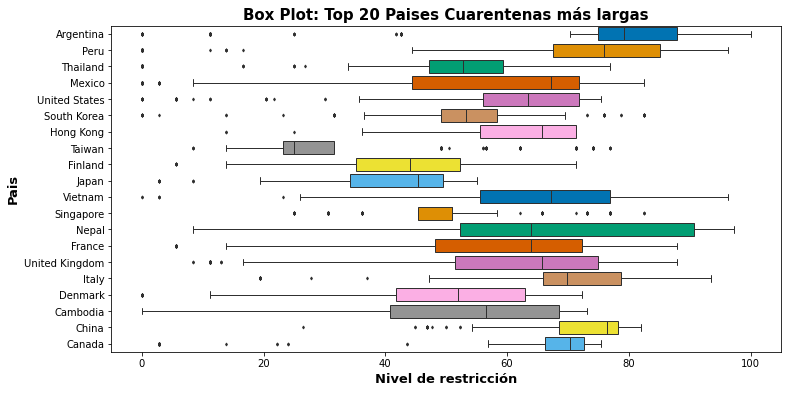

In [90]:
# Creación de box-plot.
n_paises = 20
fig_h = 1 + 0.25 * max(1, n_paises)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x='stringency_index', y='location', data=df_top,
                 order=df_order['pais'].to_list(),
                 palette="colorblind",
                 saturation=1,
                 linewidth=1,
                 fliersize=2)
plt.title('Box Plot: Top {} Paises Cuarentenas más largas'.format(top_n),fontsize=15, fontweight='heavy')
plt.xlabel('Nivel de restricción', fontsize=13, fontweight='demi')
plt.ylabel('Pais', fontsize=13, fontweight='demi')
plt.show()

Se observa como fue la distribución del nivel de restricción durante toda la pandemia. A continuación los que aplicaron medidas más estricas en promedio

#### **g.4 Paises que aplicaron medidas más estricas en promedio** <a class="anchor" id="section_2_2_4"></a>
[Tabla de contenidos](#TOC)

In [91]:
#df_cuarentena.sort_values(by='mean_restriccion',ascending=False)[0:top_n].reset_index()

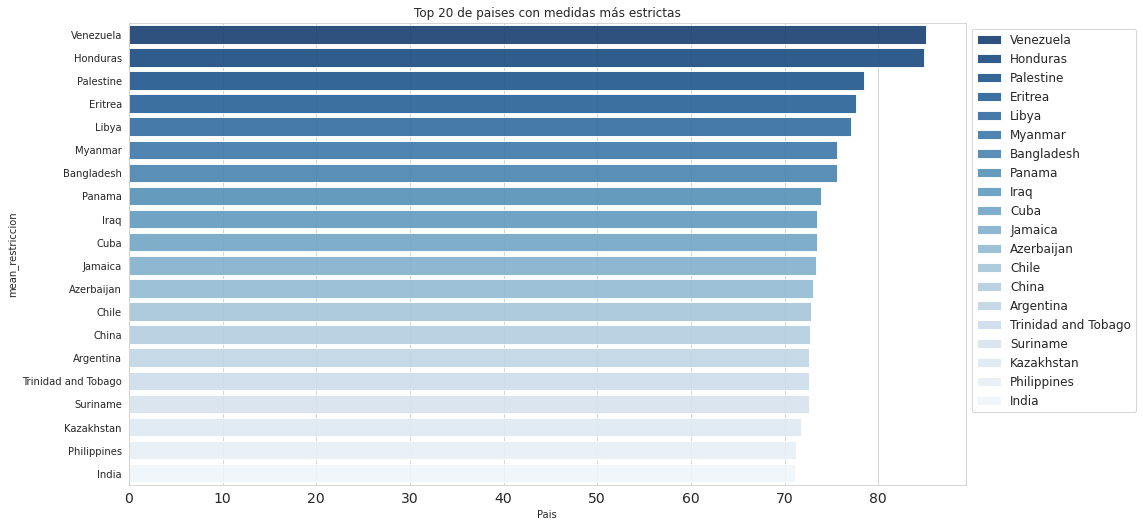

In [92]:
top = df_cuarentena.sort_values(by='mean_restriccion',ascending=False)[0:top_n].reset_index()
#top20['hours']=top20['hours'].round(1)
fig_h = 1 + 0.25 * max(1, 2*15)
fig, axes = plt.subplots(figsize=(15, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
#axes = sns.barplot(x='pais', y='mean_restriccion', hue='pais',alpha=0.9,data=top, palette='Blues_r',dodge=False)
axes = sns.barplot(x='mean_restriccion', y='pais', hue='pais',alpha=0.9,data=top, palette='Blues_r',dodge=False)
axes.set(xlabel='Pais', ylabel='mean_restriccion', title='Top {} de paises con medidas más estrictas'.format(top_n))
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#axes.set_title('Top 20 de paises')
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=10)
#axes.set_yticklabels(axes.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

Lista de paises sin cuarentena o que la cuarentena fue muy leve, considereamo leve a un valor menor a 30

#### **g.5 Análisis de cuarentenas en el primer periodo** <a class="anchor" id="section_2_2_5"></a>
[Tabla de contenidos](#TOC)
    
Analizamos ahora en el primer periodo como fue el comportamiento de las cuarentenas en los paises, tomaremos los primeros 60 días desde detectado el/los primeros casos en cada pais.

In [93]:
df = datos_orig.copy()

In [94]:
## Filtramos los primeros dias de cada pais desde cuando aparecio el primer caso

#lista_paises_x = df.location.unique()[0:5]
lista_paises_x = df.location.unique()

df_out = pd.DataFrame()
#print("Lista Paises {}".format(lista_paises_x))

for x_pais in tqdm(lista_paises_x):
    #print(x_pais)
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    #print(ind_xpais)
    casos_xpais=confirmados[ind_xpais]
    #print(casos_xpais)
    lst = list(casos_xpais)
    #print(lst)
    
    if len(ind_xpais) > casos_xpais.isna().sum():
        #print("La mayoria de las instancias de {} no son nulas o nan".format(x_pais))
        #df_pais_split.dropna(inplace=True)
        primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
        #print(primer_caso)
        ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
        #print(ind_x)
        ################# Indices   
        dia_desfase = 0
        ind_inicio = ind_x + dia_desfase
        ind_final = ind_inicio + dia_desfase + 60
        #print("ind_inicio {} a  ind_final {}".format(ind_inicio,ind_final) )
        df_pais_split = df[df['location'] == x_pais][ind_inicio:ind_final]
        #print(df[df['location'] == x_pais].shape)
        #[ind_inicio:ind_final][ind_inicio:ind_final]
        #result = pd.concat([df_pais_split, df4])
        df_out = df_out.append(df_pais_split)
    #else:
        #print("La mayoria de las instancias de {} son nulas o nan".format(x_pais))
df_out.shape

100%|██████████| 233/233 [00:06<00:00, 34.13it/s]


(12120, 65)

In [95]:
#df_out[df_out['location'] == 'Argentina']

In [96]:
df = df_out.copy()

In [97]:
df_cuarentena = df.groupby(by='location')['stringency_index'].agg(['count','sum','median','mean']).sort_values(by='median',ascending=False)
#df_cuarentena['median']
df_cuarentena.shape

(202, 4)

In [98]:
#paises que no hicieron cuarentena
#df_sin_cuerentena = df_cuarentena.to_frame()
df_sin_cuarentena = df_cuarentena[df_cuarentena['count'].sort_values(ascending=True) == 0]

df_sin_cuarentena = pd.DataFrame(df_sin_cuarentena)
df_sin_cuarentena['pais'] = df_sin_cuarentena.index
#df_sin_cuerentena.drop(['B', 'C'], axis=1)
df_sin_cuarentena = df_sin_cuarentena['pais']
#df_sin_cuerentena.rename({'app_name': 'cnt'}, axis=1, inplace=True)
df_sin_cuarentena.reset_index(drop=True, inplace=True)
df_sin_cuarentena = pd.DataFrame(df_sin_cuarentena)
df_sin_cuarentena = df_sin_cuarentena[['pais']].sort_values(['pais'], ascending=True)
print("a primera vista hay {} paises que no realizaron cuarentena".format(df_sin_cuarentena.size))
df_sin_cuarentena.head(10)

a primera vista hay 27 paises que no realizaron cuarentena


,pais
0,Africa
1,Antigua and Barbuda
2,Armenia
3,Asia
4,Comoros
5,Equatorial Guinea
6,Europe
7,European Union
8,Grenada
9,Guinea-Bissau


Filtramos los continentes y demás que no corresponden con paises.

In [99]:
list_quitar = ['World','South America','Oceania','European Union','Europe','Asia','Africa']

In [100]:
df_sin_cuarentena = df_sin_cuarentena[~df_sin_cuarentena.isin(list_quitar)]

In [101]:
#Dropeamos los nulos y reseteamos el indice
df_sin_cuarentena.dropna(inplace=True)
df_sin_cuarentena.reset_index(drop=True, inplace=True)
print("Quitando los datos que no corresponden hay {} paises que no realizaron cuarentena".format(df_sin_cuarentena.size))
df_sin_cuarentena.head()

Quitando los datos que no corresponden hay 20 paises que no realizaron cuarentena


,pais
0,Antigua and Barbuda
1,Armenia
2,Comoros
3,Equatorial Guinea
4,Grenada


In [102]:
# lista de paises sin cuarentena elegidos 
#list_pais_sin_cuarentena = df_sin_cuarentena['pais']
#list_pais_sin_cuarentena

Ahora vamos a ver los paises que si realizaron cuarentena, también filtramos los que no corresponden. 

In [103]:
# Definir el top de paises a filtrar
top_n = 20

In [104]:
df_cuarentena = pd.DataFrame({'pais': df_cuarentena.index,
                                        'dias_cuarentena': df_cuarentena['count'].values,
                                        'acum_restriccion': df_cuarentena['sum'].values,
                                        'mean_restriccion': df_cuarentena['mean'].values,
                                        'median_restriccion': df_cuarentena['median'].values
                                 })

# ordenamos los paises con la cuarentena más larga
#df_cuarentena = df_cuarentena.sort_values(by='dias_cuarentena',ascending=False)[0:top_n]

In [105]:
#filtramos los que no correspondan, los de la lista lista_quitar
df_cuarentena = df_cuarentena[~df_cuarentena.pais.isin(list_quitar)]

In [106]:
# mostramos el top n
df_cuarentena[0:top_n]

,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
0,Honduras,60,5593.51,93.225167,100.00
1,Argentina,60,4623.16,77.052667,100.00
2,Jordan,60,4637.94,77.299000,100.00
3,Libya,60,5768.52,96.142000,100.00
4,Serbia,60,5036.16,83.936000,100.00
5,Congo,60,4708.26,78.471000,97.22
6,Laos,60,5012.22,83.537000,96.30
7,Palestine,60,5381.58,89.693000,96.30
8,Croatia,60,3947.36,65.789333,96.30
9,Bahamas,60,5392.76,89.879333,96.30


In [107]:
df_cuarentena.pais.shape

(195,)

Calculamos los estadísticos

In [108]:
df_cuarentena.describe()

,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
count,195.000000,195.000000,175.000000,175.000000
mean,53.846154,3325.452872,61.758410,68.299000
std,18.250178,1613.898814,20.328412,26.977233
min,0.000000,0.000000,8.163667,0.000000
25%,60.000000,2289.325000,53.538167,60.650000
50%,60.000000,3859.120000,65.892333,78.240000
75%,60.000000,4493.985000,76.489167,87.040000
max,60.000000,5768.520000,96.142000,100.000000


#### **g.6 Graficamos la distribución de los días de cuarentena y su severidad (primer periodo)** <a class="anchor" id="section_2_2_6"></a>
[Tabla de contenidos](#TOC)

Graficamos la distribución de los días de cuarentena y su severidad.

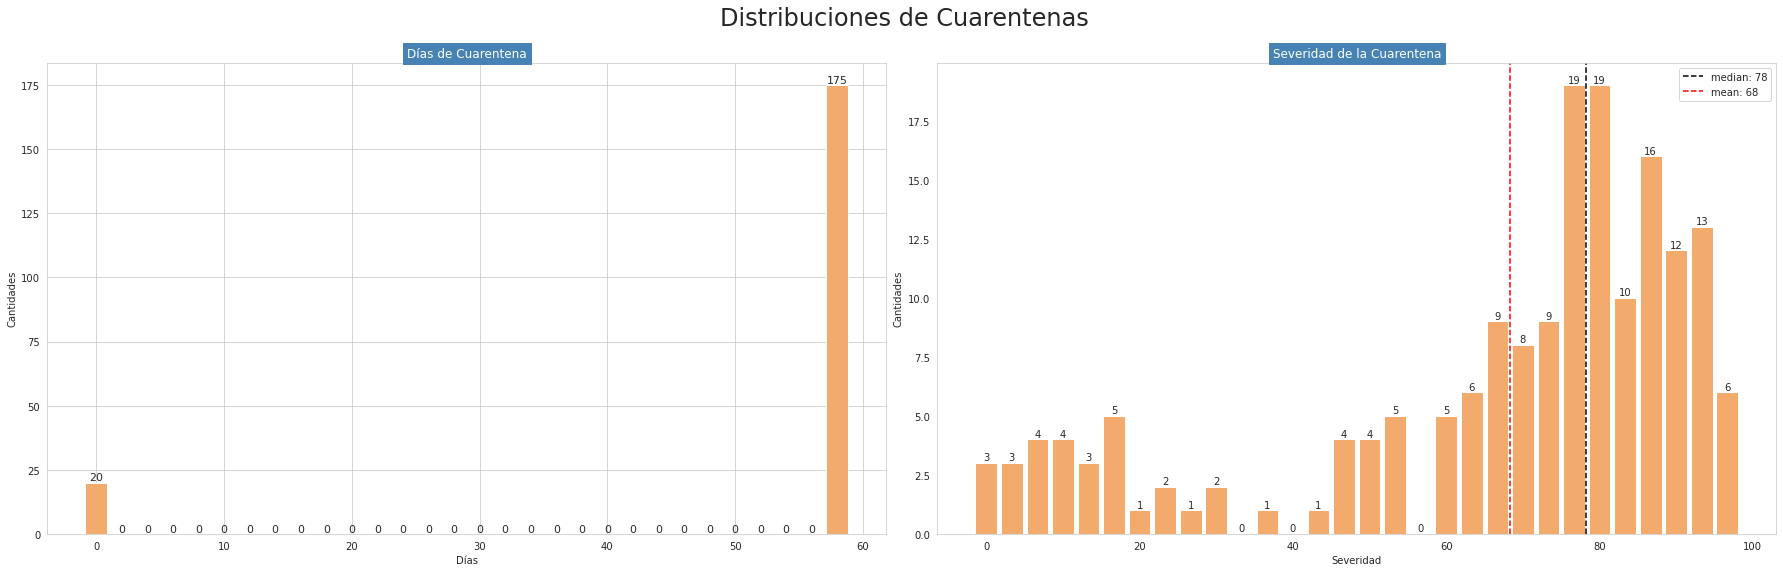

In [109]:
#intervalos = range(int(min(df_cuarentena['acum_restriccion'])), int(max(df_cuarentena['acum_restriccion'])) + 2) #calculamos los extremos de los intervalos
intervalo1 = 30
intervalo2 = 30

## creamos la figura con subplots de 1 linea 2 columnas
fig, axes = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Distribuciones de Cuarentenas', fontsize=24)
#padding between subplots. Pass a float parameter to specify the amount of padding between subplots.
fig.tight_layout(pad=2.0)
plt.grid()

# Grafico 0
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

#sns.countplot(data = df, x = "price", orient='v', order = df['price'].value_counts().index)
axes[0].set_title("Días de Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[0].hist(x=df_cuarentena['dias_cuarentena'], bins=intervalo1, color='#F2AB6D', rwidth=0.85, align='left')
#axes.set_title("Todas los tipos: ",fontsize = 10, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].set_xlabel("Días")
axes[0].set_ylabel("Cantidades")
#axes[0].set_xlim([47,215]) ## limite en x, para acotar y quitar los outliers
#axes[0].axvline(x=df_cuarentena['dias_cuarentena'].median(), color='black', linestyle='--', label=label_median)
#axes[0].axvline(x=df_cuarentena['dias_cuarentena'].mean(), color='red', linestyle='--', label=label_mean)
#axes[0].legend()

count=0
for rect in axes[0].patches:
    count +=1
    if count <= intervalo1:  
        # prints the quit message
        #print(quit)
        axes[0].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,int(rect.get_height()),horizontalalignment='center', fontsize = 11)

#Grafico 1
label_median = "median: {}".format( int(df_cuarentena['median_restriccion'].median()) )
label_mean = "mean: {}".format( int(df_cuarentena['median_restriccion'].mean()) )

axes[1].set_title("Severidad de la Cuarentena",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
axes[1].hist(x=df_cuarentena['median_restriccion'], bins=intervalo2, color='#F2AB6D', rwidth=0.85, align='left')

#plt.sca(axes[0, 1])
#plt.sca(axes[0])
plt.xticks(rotation=0)
axes[1].set_xlabel("Severidad")
axes[1].set_ylabel("Cantidades")
#axes[1].set_xlim([0,10]) ## limite en x, para acotar y quitar los outliers
axes[1].axvline(x=df_cuarentena['median_restriccion'].median(), color='black', linestyle='--', label=label_median)
axes[1].axvline(x=df_cuarentena['median_restriccion'].mean(), color='red', linestyle='--', label=label_mean)

axes[1].legend()

count=0
for rect in axes[1].patches:
    count +=1
    if count <= intervalo2:
        #if int(rect.get_height()) > 0:
        #print(int(rect.get_height()))
        #axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 10)
        axes[1].text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.1,int(rect.get_height()),horizontalalignment='center', fontsize = 10)
plt.show()

#### **g.7 Distribución de los días de cuarentena y su severidad (primer periodo)** <a class="anchor" id="section_2_2_7"></a>
[Tabla de contenidos](#TOC)

Graficamos la distribución de los días de cuarentena y su severidad.

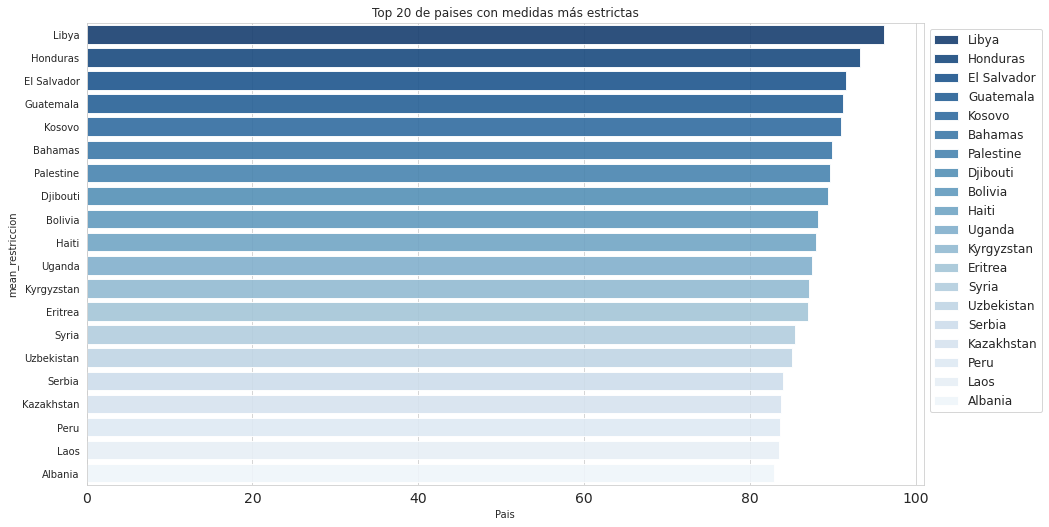

In [110]:
top = df_cuarentena.sort_values(by='mean_restriccion',ascending=False)[0:top_n].reset_index()
#top20['hours']=top20['hours'].round(1)
fig_h = 1 + 0.25 * max(1, 2*15)
fig, axes = plt.subplots(figsize=(15, fig_h))

#plt.figure(figsize=(20, 8))
#axes = sns.set(font_scale = 2)
#axes = sns.barplot(x='pais', y='mean_restriccion', hue='pais',alpha=0.9,data=top, palette='Blues_r',dodge=False)
axes = sns.barplot(x='mean_restriccion', y='pais', hue='pais',alpha=0.9,data=top, palette='Blues_r',dodge=False)
axes.set(xlabel='Pais', ylabel='mean_restriccion', title='Top {} de paises con medidas más estrictas'.format(top_n))
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#axes.set_title('Top 20 de paises')
#axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=10)
#axes.set_yticklabels(axes.get_yticklabels(), rotation=0, fontsize=10)
axes.xaxis.set_tick_params(labelsize=14)
axes.legend(fontsize=12,bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

#### **g.8 Elección paises que realizaron cuarentena o no (primer periodo)** <a class="anchor" id="section_2_2_8"></a>
[Tabla de contenidos](#TOC)

In [111]:
# ordenamos los paises con la cuarentena más larga
df_order = df_cuarentena.sort_values(by='mean_restriccion',ascending=False).reset_index()
df_order.head()

,index,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
0,3,Libya,60,5768.52,96.142000,100.00
1,0,Honduras,60,5593.51,93.225167,100.00
2,35,El Salvador,60,5498.11,91.635167,88.89
3,17,Guatemala,60,5476.97,91.282833,93.52
4,22,Kosovo,60,5456.32,90.938667,92.59


In [112]:
#df_order[150:155]

In [113]:
#df_order[df_order['pais'] == 'Finland']

In [114]:
#lista de paises que no realizaron cuarentenas estrictas
list_pais_sin_cuarentena = ['United Kingdom','Brazil','United States','France','Spain']

In [115]:
#lista de paises que realizaron cuarentenas estrictas
list_pais_con_cuarentena = ['Argentina', 'Peru', 'China','Paraguay','New Zealand']

In [116]:
df_order.loc[df_order['pais'].isin(list_pais_sin_cuarentena)]

,index,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
130,106,Brazil,60,3249.63,54.160500,73.15
150,163,Spain,60,1925.89,32.098167,11.11
158,170,France,60,1602.42,26.707000,5.56
164,161,United Kingdom,60,1383.74,23.062333,11.11
171,169,United States,60,847.79,14.129833,5.56


In [117]:
df_order.loc[df_order['pais'].isin(list_pais_con_cuarentena)]

,index,pais,dias_cuarentena,acum_restriccion,mean_restriccion,median_restriccion
17,13,Peru,60,5021.11,83.685167,94.44
34,63,Paraguay,60,4708.25,78.470833,82.41
40,1,Argentina,60,4623.16,77.052667,100.00
48,93,China,60,4506.47,75.107833,77.31
83,11,New Zealand,60,4065.78,67.763000,96.30


In [118]:
#df_cuarentena
#df_cuarentena.sort_values(by='mean_restriccion',ascending=True)[50:100].reset_index()

### **h. Analisis de indicadores y módelo Regresión Logística**  <a class="anchor" id="section_2_3"></a>
[Tabla de contenidos](#TOC)


#### **h.1 Definición de indicadores y analisis para un pais** <a class="anchor" id="section_2_3_1"></a>
[Tabla de contenidos](#TOC)


Se eligen como indicadores el número de nuevas muertes, la tasa de reproducción  y la variabilidad del factor K.

In [119]:
muertes_nuevas = datos_orig['new_deaths'] #carga vector todos las muertes confirmadas
muertes_acum = datos_orig['total_deaths'] #carga vector todos las muertes confirmadas
uci_nuevas = datos_orig['icu_patients']
reproduction_rate = datos_orig['reproduction_rate']
new_cases = datos_orig['new_cases']
new_deaths =  datos_orig['new_deaths']
new_tests =  datos_orig['new_tests']
new_cases_per_millon = datos_orig['new_cases_per_million']
new_deaths_per_millon =  datos_orig['new_deaths_per_million']

In [120]:
paises=datos2['location'] #cargo el vector de paises
confirmados=datos2['total_cases'] #carga vector todos los casos confirmados
population=datos2['population'] #carga vector todos los casos confirmados

Definimos función `variabilidad_k` para analizar la variabilidad de K según los casos y días transcurridos

In [121]:
#definimos función para analizar la variabilidad de K según los casos y días transcurridos
def variabilidad_k (casos,t,t0):
    k = np.log(casos) / (t-t0)
    return k

Definimos la función `analizar_pais` para analizar los indicadores

In [122]:
## Inicio de analisis

#for x_pais in tqdm(lista_paises):
def analizar_pais(x_pais,xmin,xmax,ymin,ymax,medida1,medida2):
    '''
    Función para analizar el comportamiento de la curva de contagios, muertes y la tasa de reproducción.
    
    Parameters
    ----------
    x_pais : str
        pais a evaluar.
    xmin: int
        limite inferior eje x
    xmay: int
        limite superior eje x
    ymin: int
        limite inferior eje y
    ymax: int
        limite superior eje 7
    medida1: int
        inicio primera medida de cuarentena
    medida2: int
        inicio de segunda medida de cuarentena
         
    Returns
    -------
    Crea el gráfico de las tres curvas: cantidad de casos acumulados, muertes y tasa de reproduccion
    '''

    ### listas
    list_variabilidad_k = []
        
    #armamos la figura para el gráfico
    fig, ax = plt.subplots(1,2,figsize=(22,6),gridspec_kw={'width_ratios': [3, 1]})
    #ax.set_title('Casos Covid {}'.format(x_pais),fontsize=18, loc='center')
    fig.suptitle('Analisis de Casos Covid', fontsize=18)
    fig.tight_layout(pad=2.0)
    
    #ax.set_xlim([0, 100])
    #ax.grid()
    #seleccionamos Argentina
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Argentina
    dia_start = datos2[datos2['location']==x_pais].date.iloc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
    
    ### Muertes_acum
    muertes_xpais=muertes_acum[ind_xpais]
    lst_muertes = list(muertes_xpais)
    primer_muerte=lst_muertes[lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x_muertes = lst_muertes.index(next(filter(lambda x: not np.isnan(x), lst_muertes)))
    dias_muerte=np.arange(0,len(muertes_xpais))
    
    
    ### Internaciones UCI
    #uci_xpais=uci_nuevas[ind_xpais]
    #lst_uci = list(uci_xpais)
    #primer_muerte=lst_uci[lst_uci.index(next(filter(lambda x: not np.isnan(x), lst_uci)))]
    ## Buscamos el indice del primer elemento no nulo
    #ind_x_uci = lst_uci.index(next(filter(lambda x: not np.isnan(x), lst_uci)))
    #dias_uci=np.arange(0,len(uci_xpais))
        
    ### reproduction_rate    
    rep_xpais=reproduction_rate[ind_xpais]
    lst_rep = list(rep_xpais)
    primer_muerte=lst_rep[lst_rep.index(next(filter(lambda x: not np.isnan(x), lst_rep)))]
    ## Buscamos el indice del primer elemento no nulo
    ind_x_rep = lst_rep.index(next(filter(lambda x: not np.isnan(x), lst_rep)))
    dias_rep=np.arange(0,len(rep_xpais))   

    #GRAFICO SUBPLOT 1
    #color de la lineas
    #color = next(ax._get_lines.prop_cycler)['color']
    ax[0].set_title("Curva casos, tasa rep, muertes y factor k",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
    ax[0].set_xlabel("Días")
    ax[0].set_ylabel("Cantidad")
    
    # Grafico Muertes acumuladas muertes_acum
    label_muertes = "Muertes {}".format(x_pais)
    #fig = plt.plot(dias_muerte,np.log(muertes_xpais), linestyle='--',color=color,label=label_muertes)
    ax[0].plot(dias_muerte,muertes_xpais, linestyle='solid',color='k',label=label_muertes)
    #plot primera muerte
    dia_start_muertes = datos2[datos2['location']==x_pais].date.iloc[ind_x_muertes]
    label_nuertes_line = "Muertes {} día inicio {} fecha {}".format(x_pais,ind_x_muertes,dia_start_muertes)
    ax[0].axvline(x=ind_x_muertes, color='k', linestyle='--',label=label_nuertes_line)    
    
    # Grafico uci
    #label_uci = "UCI {}".format(x_pais)
    #fig = plt.plot(dias_uci,np.log(uci_xpais), linestyle='dotted',color=color,label=label_uci)  
    
    ###grafico tasa de reproducción 
    label_rep = "Tasa Rep {}".format(x_pais)
    #fig = plt.plot(dias_rep,np.log(rep_xpais), linestyle='dashdot',color=color,label=label_rep)
    ax[0].plot(dias_rep,rep_xpais, linestyle='solid',color='g',label=label_rep)
    #plot primera tasa rep
    dia_start_rep = datos2[datos2['location']==x_pais].date.iloc[ind_x_rep]
    label_rep_line = "Tasa Rep {} día inicio {} fecha {}".format(x_pais,ind_x_rep,dia_start_rep)
    ax[0].axvline(x=ind_x_rep, color='g', linestyle='dashdot',label=label_rep_line)

    ## Graficamos
    #fig, ax = plt.subplots(figsize=(8,3))
    label_casos="Casos {}".format(x_pais)
    dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)    
    ax[0].plot(dias,np.log(casos_xpais),color=color,label=label_casos)
    #plt.xlabel('dias')
    #plt.ylabel('log cantidad de casos')
    ax[0].set_xlabel("dias")
    ax[0].set_ylabel("log cantidad de casos")
    
    #ax.set_xticklabels(models, rotation=0)
    #plot primera caso
    label_casos_line = "Primer caso {} día {} fecha {}".format(x_pais,ind_x,dia_start)
    ax[0].axvline(x=ind_x, color='red', linestyle='--',label=label_casos_line)

    ##grafico línea comienzo cuarentena
    # primera medida de cuarentena diax 
    dia_start_medida1 = datos2[datos2['location']==x_pais].date.iloc[ind_x + medida1]
    label_cuarentena_line = "Cuarentena medida1 {} día inicio {}".format(x_pais,dia_start_medida1)
    ax[0].axvline(x=ind_x+medida1, color='blue', linestyle='--',label=label_cuarentena_line)
    ax[1].axvline(x=ind_x+medida1, color='blue', linestyle='--',label=label_cuarentena_line)

    ##grafico línea cierre de fronteras
    # segunda medida de cuarentena diax 
    dia_start_medida2 = datos2[datos2['location']==x_pais].date.iloc[ind_x + medida2]
    label_cuarentena_line2 = "Cuarentena medida2 {} día inicio {}".format(x_pais,dia_start_medida2)
    ax[0].axvline(x=ind_x+medida2, color='blue', linestyle='dashdot',label=label_cuarentena_line2)
    ax[1].axvline(x=ind_x+medida2, color='blue', linestyle='dashdot',label=label_cuarentena_line2)

    
    #### Calculamos el k
    #seleccionamos Pais
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    ##poblacion x pais
    poblacion_xpais=int(population[0])
    #casos
    casos_xpais=confirmados[ind_xpais]
    dias=np.arange(0,len(casos_xpais))
    #Imputamos los nan con 0
    #casos_xpais.fillna(0, inplace=True)    
        
    ################# Estimamos K
        
    dia_desfase = 0
    ind_inicio = ind_x + dia_desfase
    ind_final = ind_inicio + dia_desfase + 60
        
    #dias=np.arange(0,len(casos_arg))
    
    #print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
    casos_principio=casos_xpais[ind_inicio:ind_final]
    dias_principio=dias[ind_inicio:ind_final]
    #print(list(dias_principio))    
    #print(list(casos_principio))
    
    # muertes nuevas
    nuevas_muertes =  datos_orig['new_deaths']
    nuevas_muertes_xpais=nuevas_muertes[ind_xpais][ind_inicio:ind_final]
    lst_nuevas_muertes = list(nuevas_muertes_xpais)
    dias_n=np.arange(ind_inicio,ind_final)
    ax[0].plot(dias_n,np.log(lst_nuevas_muertes),color='m',linestyle=':', label='Nuevas Muertes')
    
    # nuevos casos 
    nuevos_casos =  datos_orig['new_cases']
    nuevos_casos_xpais=nuevos_casos[ind_xpais][ind_inicio:ind_final].fillna(method="ffill")
    lst_nuevos_casos = list(nuevos_casos_xpais)
    dias_n=np.arange(ind_inicio,ind_final)
    ax[0].plot(dias_n,np.log(lst_nuevos_casos),color='cyan',linestyle='dotted',label='Nuevos Casos')


    #ajustamos, popt[0] es nuestro "K" y popt[1] t0
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
    #popt
    
    #Guardamos el valor de k y t0 en la lista:
    lista_k.append(popt[0])
    lista_t0.append(popt[1])
    #lista_casos_max.append(casos_principio.max())
    #lista_population.append(poblacion_xpais)
        
    # Ajustamos los datos con los valores de los parámetros obtenidos
    k=popt[0]
    t0=popt[1]
    #print("PARAMETRO K: ",k)    
    #print("PARAMETRO t0: ",t0)
    #print(dias_principio.size)
    #print(casos_principio.size)
    #print(casos_principio.min())
    #print(casos_principio.max())
    
    ###
    casos_max = int(casos_xpais[ind_inicio:ind_final].max())
    casos_mean = int(casos_xpais[ind_inicio:ind_final].mean())
    #print("Cantidad casos max {}".format(casos_max) )
   
    #### variabilidad de k
    ind_inicio_casos = ind_x
    ##print("indice k {}".format(ind_inicio_casos))
    longitud_casos = len(lst) - ind_inicio_casos
    ##print(lst)
    ##print("VVVVVVVV {}".format(longitud_casos))
    for indice_k in np.arange(0,longitud_casos):
        #print(indice_k)
        casosx = lst[ind_inicio_casos]
        #print("{} casos {}".format(indice_k,casosx))
        ind_inicio_casos = ind_inicio_casos + 1
        t=indice_k
        t0=np.median(lista_t0)  #definido al crear el modelo
        # Elevamos al cuadrado para maximizar los valores de k
        k_var = variabilidad_k(casosx,t,t0)
        #print("kkkkkkkkk {}".format(k_var))
        list_variabilidad_k.append(k_var)
        #casos = datos2[datos2['location']=='Argentina'].total_cases.loc[ind_xpais]
        #casosx=casosx[indice_k]
        #print("casos {}".format(casosx))
     
    ### grafico de la variabilidad de K
    #dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)
    escalador = (casos_max/casos_mean)

    variabilidad_k_escalado = list(pow(np.array(list_variabilidad_k),0.035) * escalador )
    ax[0].plot(variabilidad_k_escalado,color='yellow',label="variabilidad K")
      
    #ax.set_xlim([xmin, xmax])
    #ax.set_xlim([ind_inicio, ind_final])
    #ax.set_ylim([ymin, ymax])
    #ax.grid()
    ax[0].legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    ax[0].legend()
    
    ax[0].set_xlim([ind_inicio,ind_final]) ## limite en x, para acotar y quitar los outliers
    ax[0].set_ylim([ymin,ymax]) ## limite en x, para acotar y quitar los outliers

    
    ##print("XXXXXX {}".format(list_variabilidad_k*casos_mean))
    #casos_simu=exponencial(dias_principio,k,t0)
    #print(list_variabilidad_k)
    
    ### GRAFICO SUBPLOT 2
    ax[1].set_title("Variabilidad del Factor K",fontsize = 12, color = "w", fontstretch=0, backgroundcolor="SteelBlue")
    #ax[1].plot(list_variabilidad_k[ind_inicio:ind_final], 'r+')
    ax[1].plot(list_variabilidad_k, 'r+')
    ax[1].set_xlabel("Días")
    ax[1].set_ylabel("Factor K")
    ax[1].set_xlim([ind_inicio,ind_final]) ## limite en x, para acotar y quitar los outliers

    #
    #print(escalador)
    return casos_xpais,muertes_xpais,rep_xpais,list_variabilidad_k,variabilidad_k_escalado,lst_nuevas_muertes,lst_nuevos_casos

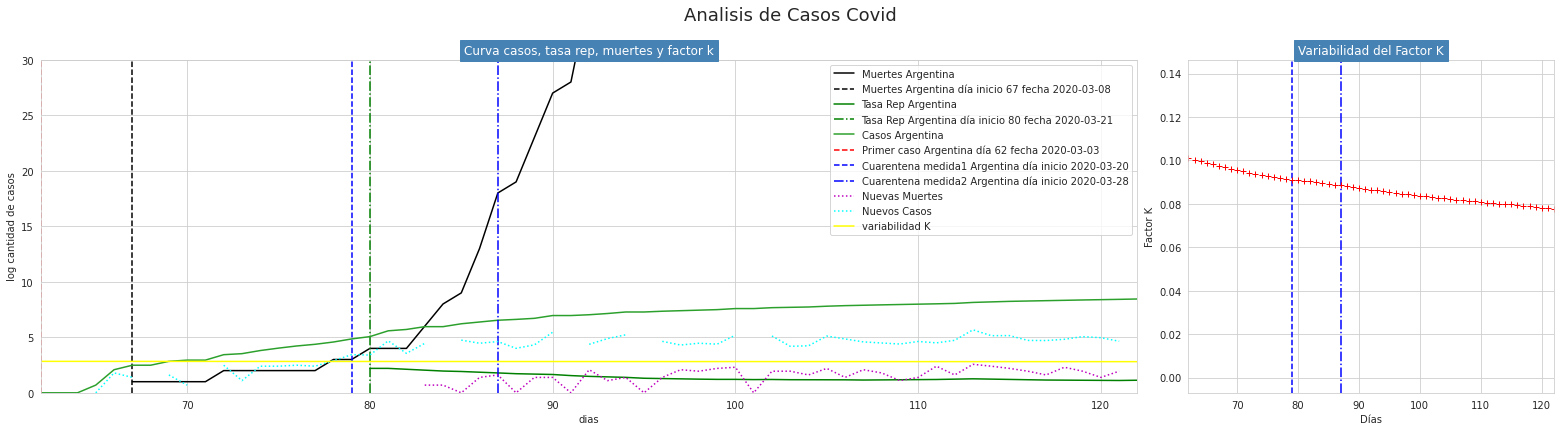

In [123]:
# nota: pasar como argumentos: 
# 1) Pais a Analizar
# 2) Inicio de ventana tiempo a analizar (ejex)
# 3) Fin de ventana tiempo a analizar (ejex)
# 4) Inicio eje y a visualizar
# 5) Fin eje y a visualizar
# 6) Días después del primer caso en que se tomó la primera medida de cuarentena significativa
# 7) Días después del primer csao en que se tomó la segunda medida de cuarentena significativa

casos_xpais,muertes_xpais,rep_xpais,list_variabilidad_k,variabilidad_k_escalado,lst_nuevas_muertes,lst_nuevos_casos = analizar_pais('Argentina',60,110,0,30,17,25) 
#casos_xpais,muertes_xpais,rep_xpais,list_variabilidad_k,variabilidad_k_escalado,lst_nuevas_muertes,lst_nuevos_casos = analizar_pais('India',0,110,0,30,17,25) 

El primer caso de covid en Argentina fue el 2020-03-03, 62 días  después de detectado el primer caso de covid en el mundo (por lo menos en los datos registrados), la primera muerte es 27 días después del primer contagio. Las primeras medidas y las más estrictas fueron tomadas el 2020-03-22 y el día 27 hubo cierre de fronteras.


#### Medidas de Cuarentena en Argentina
* El 19 de marzo de 2020, el Poder Ejecutivo Nacional dictó el DNU N° 297/2020 que dispuso
el aislamiento social, preventivo y obligatorio (ASPO) para todas las personas que
habitan en el país o se encontraran en él en forma temporaria al momento de su dictado
* Paralelamente se fueron endureciendo las medidas de cierre de fronteras. Así, a la
prohibición de ingresar al país para personas extranjeras no residentes en el país, el
Decreto DNU Nº 313/2020, del 27 de marzo


Según los datos epidemiologicos, los resultados de las medidas tomadas se pueden observar a partir de 20 días de aplicadas las mismas.

Gráfico solo variabilidad_k_escalado

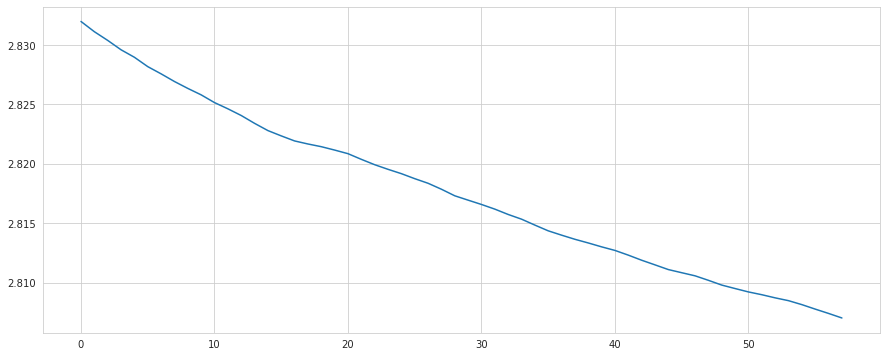

In [124]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(variabilidad_k_escalado[62:120])
plt.show()

#### **h.2 Evaluación de indicadores para paises que NO realizaron cuarentena muy estrica** <a class="anchor" id="section_2_3_2"></a>
[Tabla de contenidos](#TOC)

Evaluamos varios paises que no realizaron cuarentena muy estricta

  0%|          | 0/5 [00:00<?, ?it/s]

United Kingdom


 20%|██        | 1/5 [00:00<00:01,  2.86it/s]

Brazil


 40%|████      | 2/5 [00:00<00:01,  2.84it/s]

United States


 60%|██████    | 3/5 [00:01<00:00,  2.45it/s]

France


 80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

Spain


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


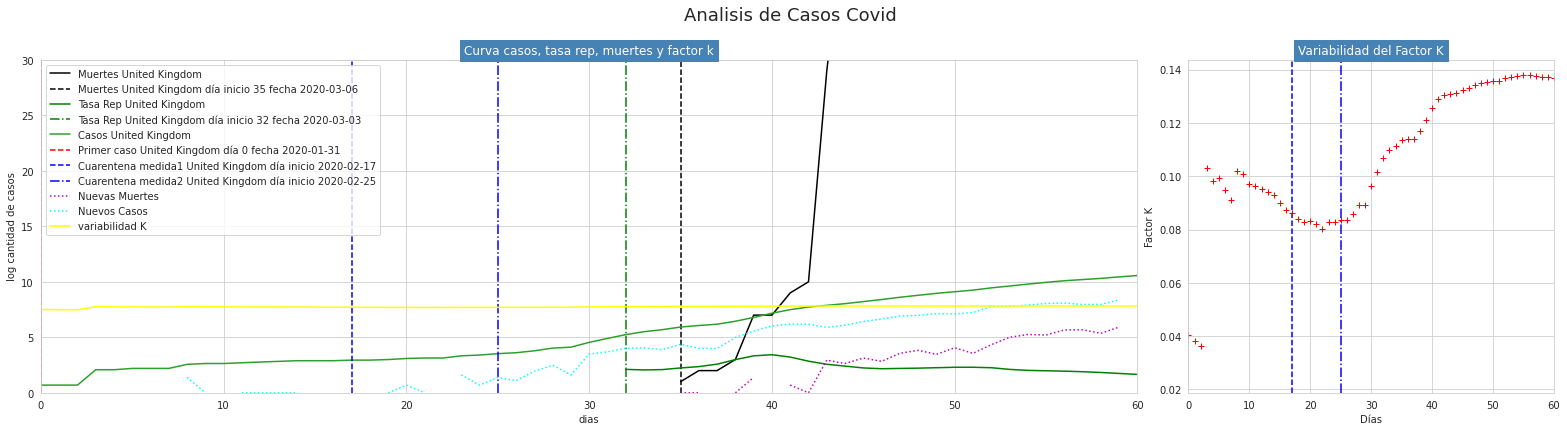

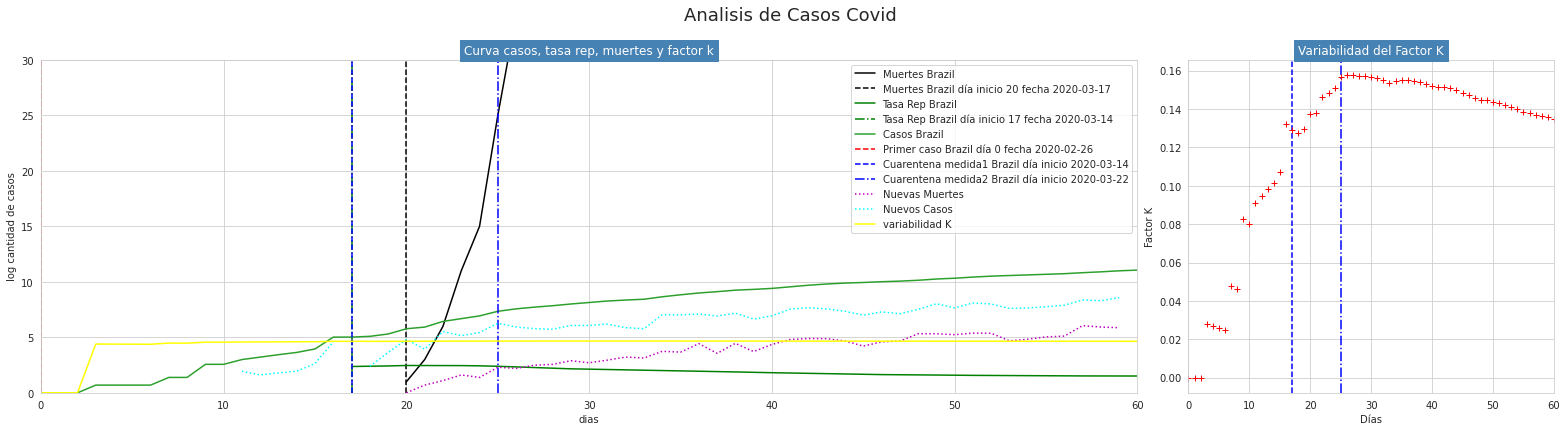

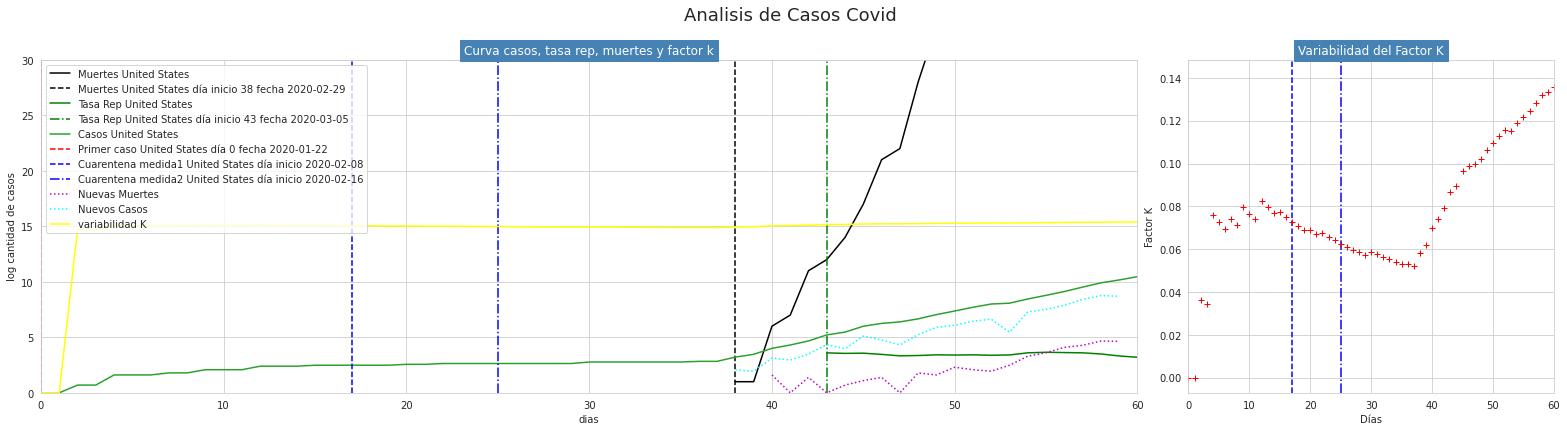

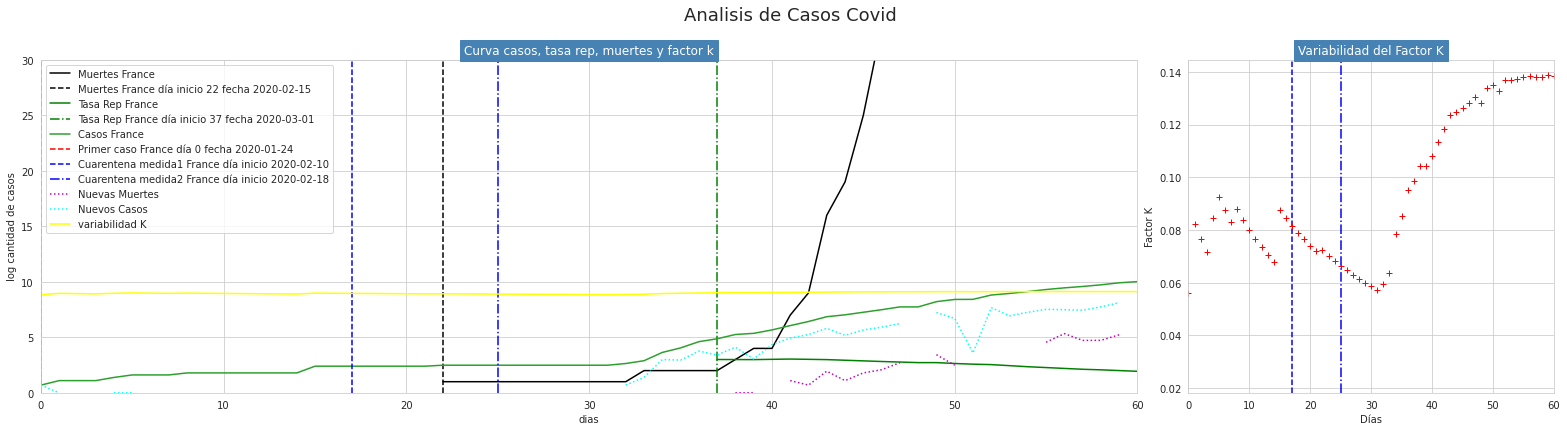

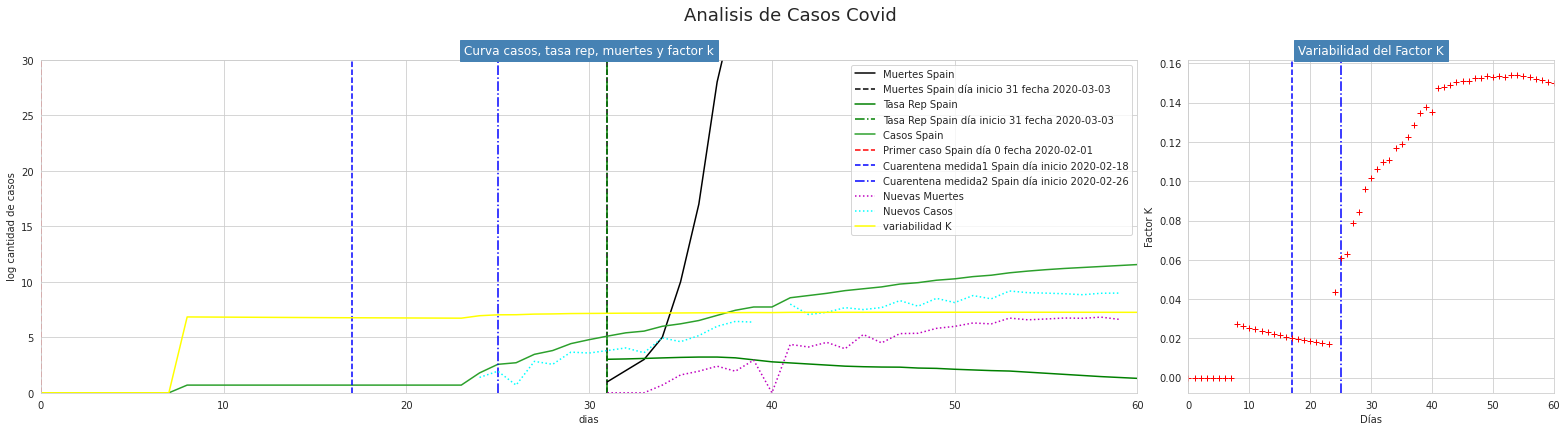

In [125]:
for x_pais in tqdm(list_pais_sin_cuarentena):
    print(x_pais)
    casos_xpais,muertes_xpais,rep_xpais,list_variabilidad_k,variabilidad_k_escalado,lst_nuevas_muertes,lst_nuevos_casos = analizar_pais(x_pais,0,60,0,30,17,25)

#### **h.3 Evaluación de indicadores para paises que si realizaron cuarentena muy estrica** <a class="anchor" id="section_2_3_3"></a>
[Tabla de contenidos](#TOC)

Evaluamos varios paises que si realizaron cuarentena muy estricta

In [126]:
### Evaluamos los paises que realizaron cuarentena

  0%|          | 0/5 [00:00<?, ?it/s]

Argentina


 20%|██        | 1/5 [00:00<00:01,  3.10it/s]

Peru


 40%|████      | 2/5 [00:00<00:01,  2.77it/s]

China


 60%|██████    | 3/5 [00:01<00:00,  2.79it/s]

Paraguay


 80%|████████  | 4/5 [00:01<00:00,  2.79it/s]

New Zealand


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


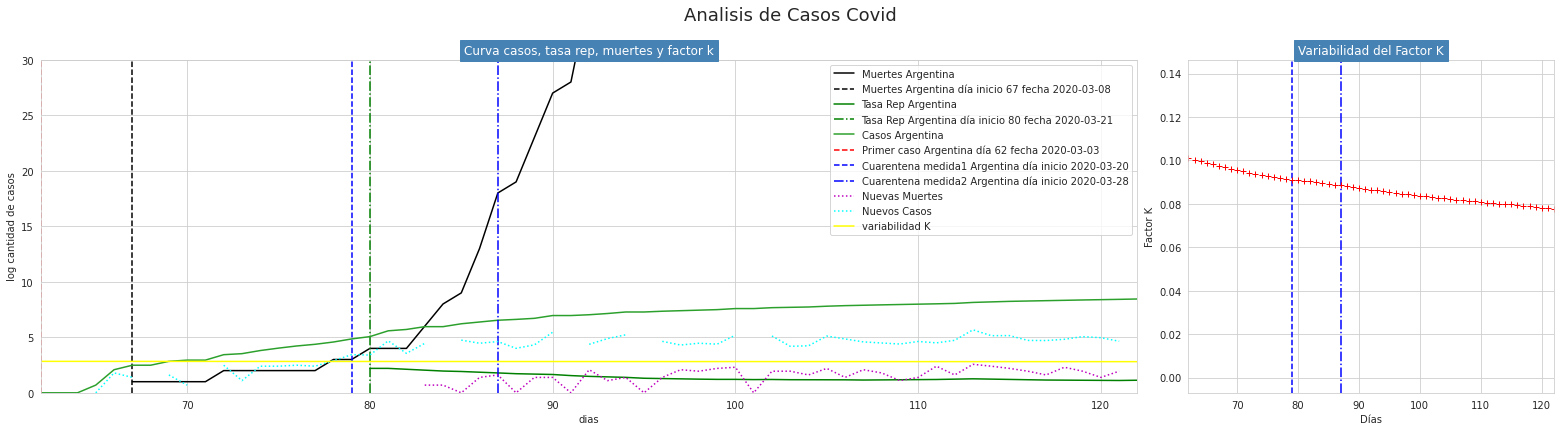

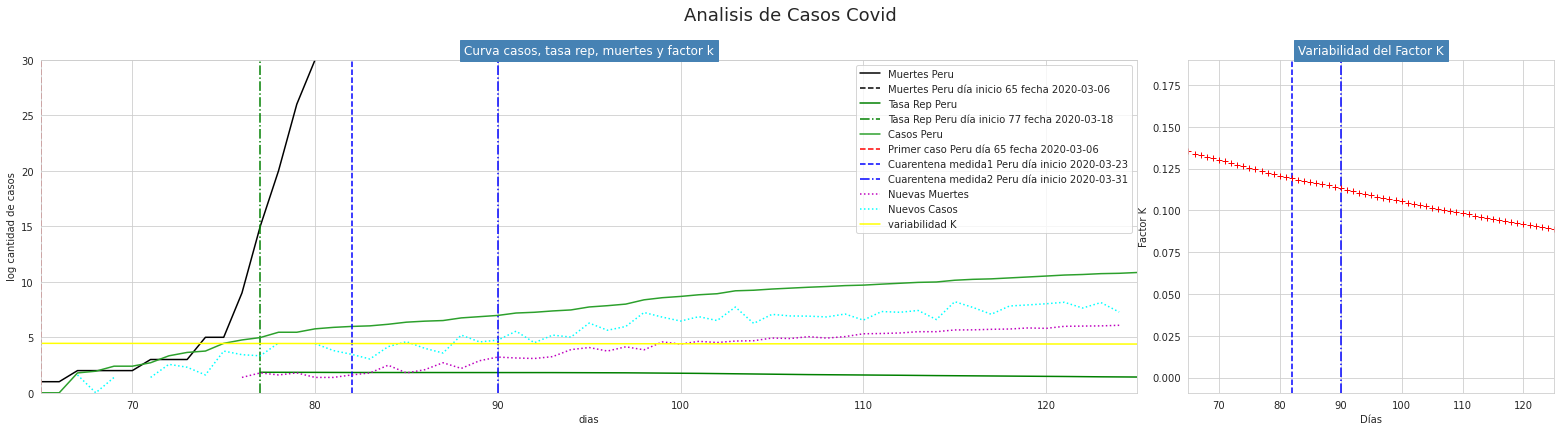

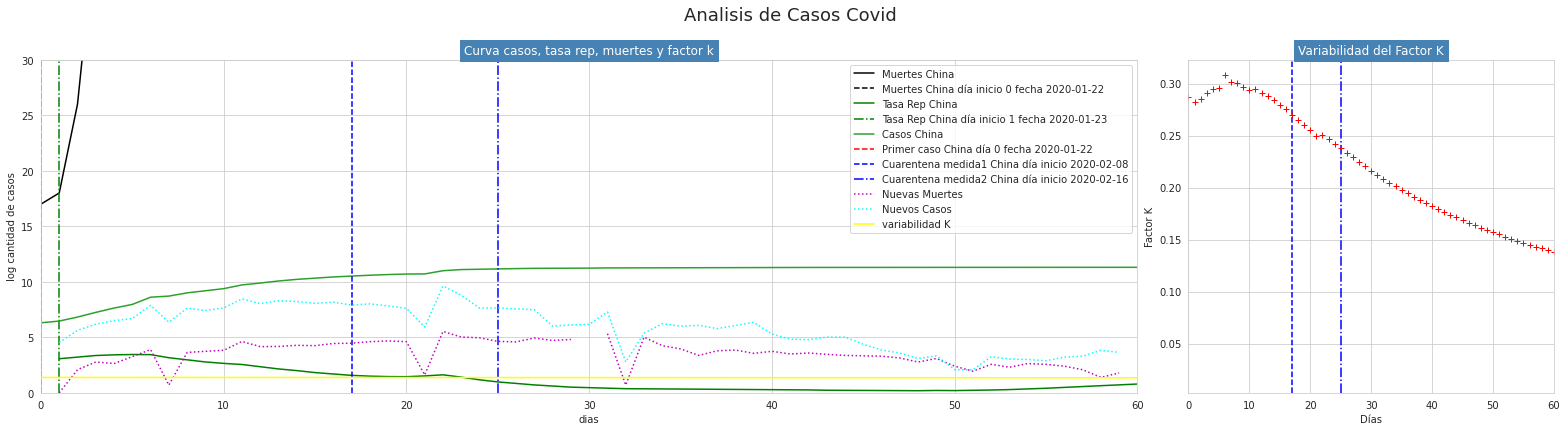

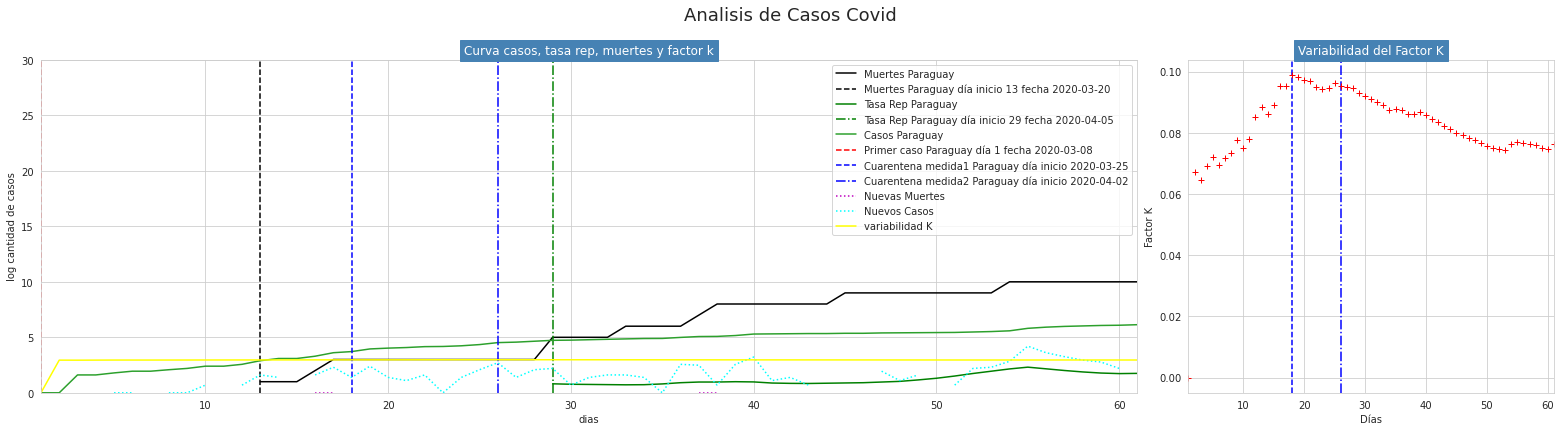

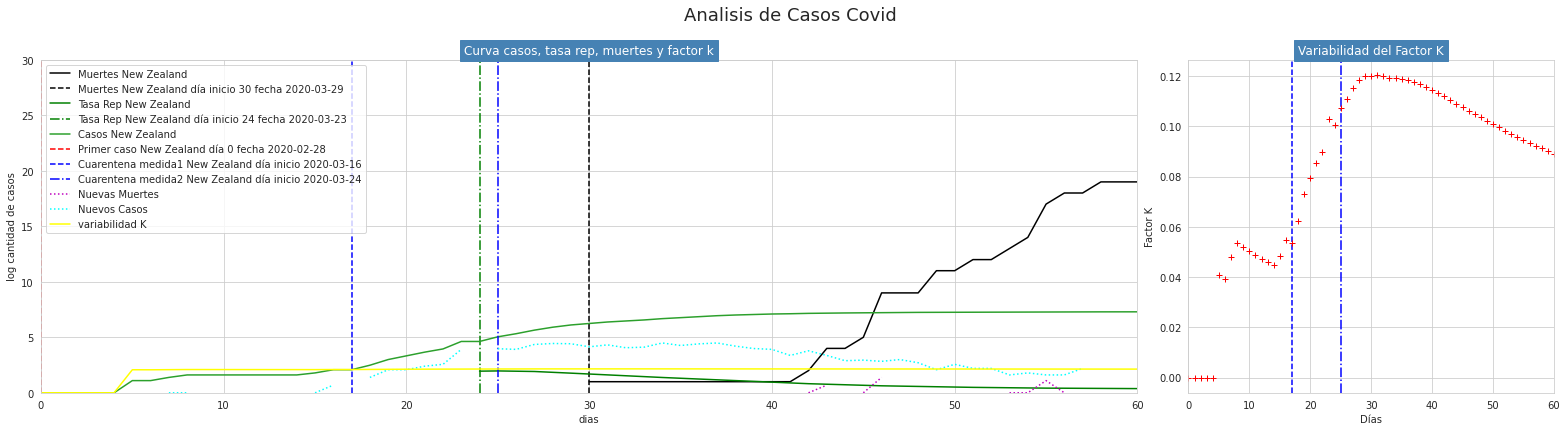

In [127]:
for x_pais in tqdm(list_pais_con_cuarentena):
    print(x_pais)
    casos_xpais,muertes_xpais,rep_xpais,list_variabilidad_k,variabilidad_k_escalado,lst_nuevas_muertes,lst_nuevos_casos = analizar_pais(x_pais,0,120,0,30,17,25)    

#### **h.4 Creación de dataframe con indicadores** <a class="anchor" id="section_2_3_4"></a>
[Tabla de contenidos](#TOC)

Definición de funcion para crear dataframe con los datos de los indicadores.

In [128]:
## Inicio de analisis

#for x_pais in tqdm(lista_paises):
def analizar_pais_df(x_pais,xmin,xmax,ymin,ymax,medida1,medida2):
    '''
    Función para analizar el comportamiento de la curva de contagios, muertes y la tasa de reproducción.
    
    Parameters
    ----------
    x_pais : str
        pais a evaluar.
    xmin: int
        limite inferior eje x
    xmay: int
        limite superior eje x
    ymin: int
        limite inferior eje y
    ymax: int
        limite superior eje 7
    medida1: int
        inicio primera medida de cuarentena
    medida2: int
        inicio de segunda medida de cuarentena
         
    Returns
    -------
    Crea el gráfico de las tres curvas: cantidad de casos acumulados, muertes y tasa de reproduccion
    '''

    ### listas
    list_casos_principio = []
    lst_muertes = []
    lst_rep = []
    list_variabilidad_k = []
        
    
    #seleccionamos Argentina
    ind_xpais=np.where(paises==x_pais)
    ind_xpais=ind_xpais[0]
    
    casos_xpais=confirmados[ind_xpais]
    
    #Transformamos a lista
    lst = list(casos_xpais)
    # Buscamos el primer valor no nulo, sería el primer día con casos
    ##from numpy import nan
    #casos_arg[np.isfinite(casos_arg)][0]
    primer_caso=lst[lst.index(next(filter(lambda x: not np.isnan(x), lst)))]
    # Buscamos el indice del primer elemento no nulo
    ind_x = lst.index(next(filter(lambda x: not np.isnan(x), lst)))
    # primer caso de covid en Argentina
    dia_start = datos2[datos2['location']==x_pais].date.iloc[ind_x]
    #print("En {} el/los primer/primeros {} casos fue el día {} indice {}".format(x_pais,primer_caso, dia_start, ind_x))
       
    ################# Indices   
    dia_desfase = 0
    ind_inicio = ind_x + dia_desfase
    ind_final = ind_inicio + dia_desfase + 60
        
    #dias=np.arange(0,len(casos_arg))
    #Cantidad de Casos
    
    #print("{} ind_inicio {}  ind_final {}".format(x_pais,ind_inicio,ind_final))
    list_casos_principio=casos_xpais[ind_inicio:ind_final]
    dias_principio=dias[ind_inicio:ind_final]
    
    ### Muertes_acum
    muertes_xpais=muertes_acum[ind_xpais]
    lst_muertes = muertes_xpais[ind_inicio:ind_final]
    
    ### reproduction_rate    
    rep_xpais=reproduction_rate[ind_xpais]
    lst_rep = rep_xpais[ind_inicio:ind_final]
    
    # muertes nuevas
    nuevas_muertes =  datos_orig['new_deaths']
    nuevas_muertes_xpais=nuevas_muertes[ind_xpais][ind_inicio:ind_final]
    lst_nuevas_muertes = list(nuevas_muertes_xpais)
    
    # muertes nuevas por millon
    nuevas_muertes_por_millon =  datos_orig['new_deaths_per_million']
    nuevas_muertes_xpais_por_millon=nuevas_muertes_por_millon[ind_xpais][ind_inicio:ind_final]
    lst_nuevas_muertes_por_millon = list(nuevas_muertes_xpais_por_millon)
    
    # nuevos casos 
    nuevos_casos =  datos_orig['new_cases']
    nuevos_casos_xpais=nuevos_casos[ind_xpais][ind_inicio:ind_final].fillna(method="ffill")
    lst_nuevos_casos = list(nuevos_casos_xpais)
    
    # Nuevos casos por millon
    nuevos_casos_por_millon =  datos_orig['new_cases_per_million']
    nuevos_casos_xpais_por_millon=nuevos_casos_por_millon[ind_xpais][ind_inicio:ind_final].fillna(method="ffill")
    lst_nuevos_casos_por_millon = list(nuevos_casos_xpais_por_millon)
    
    ## factor K
    popt, pcov = curve_fit(exponencial, dias_principio, list_casos_principio)
    #Guardamos el valor de k y t0 en la lista:
    #lista_k.append(popt[0])
    
    #### variabilidad de k
    casos_max = int(casos_xpais[ind_inicio:ind_final].mean())
    #print("Cantidad casos max {}".format(casos_max) )

    ind_inicio_casos = ind_x
    ##print("indice k {}".format(ind_inicio_casos))
    longitud_casos = len(list_casos_principio)
    ##print(lst)
    ##print("VVVVVVVV {}".format(longitud_casos))
    
    for indice_k in np.arange(0,longitud_casos):
        #print(indice_k)
        casosx = lst[ind_inicio_casos]
        #print("{} casos {}".format(indice_k,casosx))
        ind_inicio_casos = ind_inicio_casos + 1
        t=indice_k
        t0=np.median(lista_t0)  #definido al crear el modelo
        # Elevamos al cuadrado para maximizar los valores de k
        k_var = variabilidad_k(casosx,t,t0)
        #print("kkkkkkkkk {}".format(k_var))
        list_variabilidad_k.append(k_var)
        #casos = datos2[datos2['location']=='Argentina'].total_cases.loc[ind_xpais]
        #casosx=casosx[indice_k]
        #print("casos {}".format(casosx))
     
    ### grafico de la variabilidad de K
    #dias=np.arange(0,len(casos_xpais))
    #ax.set_xticklabels(models, rotation=0)   
    #variabilidad_k_escalado = list(np.array(list_variabilidad_k) * casos_max )
    
    variabilidad_k_escalado = np.array(np.array(list_variabilidad_k) * casos_max ).flatten()
    list_variabilidad_k = np.array(list_variabilidad_k).flatten()
    #print(statistics.mean(list_variabilidad_k))
    #list_variabilidad_k = list_variabilidad_k
    
    ## rellenar los nulos
    list_casos_principio = [0 if math.isnan(x) else x for x in list_casos_principio]
    lst_muertes = [0 if math.isnan(x) else x for x in lst_muertes] 
    lst_rep = [0 if math.isnan(x) else x for x in lst_rep]
    lst_nuevos_casos = [0 if math.isnan(x) else x for x in lst_nuevos_casos]
    lst_nuevas_muertes = [0 if math.isnan(x) else x for x in lst_nuevas_muertes]
    lst_nuevos_casos_por_millon = [0 if math.isnan(x) else x for x in lst_nuevos_casos_por_millon]
    lst_nuevas_muertes_por_millon = [0 if math.isnan(x) else x for x in lst_nuevas_muertes_por_millon]
    list_variabilidad_k = [0 if math.isnan(x) else x for x in list_variabilidad_k]
    variabilidad_k_escalado = [0 if math.isnan(x) else x for x in variabilidad_k_escalado]
    
    #### Creacion dataframe
    
    ## daaframes con el promedio
    df_analizar_pais_mean = pd.DataFrame({'pais': x_pais,
                                        'casos': statistics.mean(list_casos_principio),
                                        'muertes': statistics.mean(lst_muertes),
                                        'tasa_rep': statistics.mean(lst_rep),
                                        'nuevos_casos': statistics.mean(lst_nuevos_casos),
                                        'nuevas_muertes': statistics.mean(lst_nuevas_muertes),
                                        'nuevos_casos_por_millon': statistics.mean(lst_nuevos_casos_por_millon),
                                        'nuevas_muertes_por_millon': statistics.mean(lst_nuevas_muertes_por_millon),
                                        'k': popt[0],
                                        'var_k': statistics.mean(list_variabilidad_k),
                                        'var_k_esc': statistics.mean(variabilidad_k_escalado),
                                         
                                 },index=[0])
    ###dataframe con los máximos
    df_analizar_pais_max = pd.DataFrame({'pais': x_pais,
                                        'casos': statistics.mean(list_casos_principio),
                                        'muertes': statistics.mean(lst_muertes),
                                        'tasa_rep': max(lst_rep),
                                        'nuevos_casos': max(lst_nuevos_casos),
                                        'nuevas_muertes': max(lst_nuevas_muertes),
                                        'nuevos_casos_por_millon': max(lst_nuevos_casos_por_millon),
                                        'nuevas_muertes_por_millon': max(lst_nuevas_muertes_por_millon),
                                        'k': popt[0],
                                        'var_k': max(list_variabilidad_k),
                                        'var_k_esc': max(variabilidad_k_escalado),
                                         
                                 },index=[0])
    
    df_analizar_pais = pd.DataFrame({'pais': x_pais,
                                        'casos': list_casos_principio,
                                        'muertes': lst_muertes,
                                        'tasa_rep': lst_rep,
                                        'nuevos_casos': lst_nuevos_casos,
                                        'nuevas_muertes': lst_nuevas_muertes,
                                        'nuevos_casos_por_millon': lst_nuevos_casos_por_millon,
                                        'nuevas_muertes_por_millon': lst_nuevas_muertes_por_millon,
                                        'k': popt[0],
                                        'var_k': list_variabilidad_k,
                                        'var_k_esc': variabilidad_k_escalado
                                 })
    
    #return list_casos_principio,lst_muertes,lst_rep,list_variabilidad_k,variabilidad_k_escalado,df_analizar_pais
    return df_analizar_pais,df_analizar_pais_mean,df_analizar_pais_max

In [129]:
#list_casos_principio,lst_muertes,lst_rep,list_variabilidad_k,variabilidad_k_escalado,df_analizar_pais = analizar_pais_df('Argentina',60,110,0,30,17,25) 

Creamos dataframe con los indicadores de los paises que no realizaron cuarentena al principio o la misma no fue muy estrica.

In [186]:
list_pais_sin_cuarentena = ['Colombia','Chile']

list_pais_con_cuarentena = ['Brazil', 'Peru']

In [188]:
df_out_indicadores_sin_cuarentena = pd.DataFrame()

for x_pais in tqdm(list_pais_sin_cuarentena):
    #print(x_pais)
    df_analizar_pais,df_analizar_pais_mean,df_analizar_pais_max = analizar_pais_df(x_pais,0,110,0,30,17,25) 
    df_out_indicadores_sin_cuarentena = df_out_indicadores_sin_cuarentena.append(df_analizar_pais)
    df_out_indicadores_sin_cuarentena['cuarentena'] = int(0)
df_out_indicadores_sin_cuarentena

100%|██████████| 2/2 [00:00<00:00, 25.71it/s]


,pais,casos,muertes,tasa_rep,nuevos_casos,nuevas_muertes,nuevos_casos_por_millon,nuevas_muertes_por_millon,k,var_k,var_k_esc,cuarentena
0,Colombia,1.0,0.0,0.00,1.0,0.0,0.020,0.000,0.058823,0.000000,0.000000,0
1,Colombia,1.0,0.0,0.00,0.0,0.0,0.000,0.000,0.058823,0.000000,0.000000,0
2,Colombia,1.0,0.0,0.00,0.0,0.0,0.000,0.000,0.058823,0.000000,0.000000,0
3,Colombia,1.0,0.0,0.00,0.0,0.0,0.000,0.000,0.058823,0.000000,0.000000,0
4,Colombia,3.0,0.0,0.00,2.0,0.0,0.039,0.000,0.058823,0.042365,97.312076,0
...,...,...,...,...,...,...,...,...,...,...,...,...
55,Chile,10598.0,126.0,1.19,907.0,10.0,47.209,0.520,0.071940,0.120475,367.449483,0
56,Chile,10956.0,133.0,1.20,358.0,7.0,18.634,0.364,0.071940,0.119356,364.034685,0
57,Chile,11375.0,139.0,1.21,419.0,6.0,21.809,0.312,0.071940,0.118319,360.872907,0
58,Chile,11700.0,147.0,1.22,325.0,8.0,16.916,0.416,0.071940,0.117191,357.433093,0


Creamos dataframe con los indicadores de paises que tuvieron una cuarentena muy estricta al principio (periodo analizado)

In [189]:
df_out_indicadores_con_cuarentena = pd.DataFrame()

for x_pais in tqdm(list_pais_con_cuarentena):
    #print(x_pais)
    df_analizar_pais,df_analizar_pais_mean,df_analizar_pais_max = analizar_pais_df(x_pais,0,110,0,30,17,25) 
    df_out_indicadores_con_cuarentena = df_out_indicadores_con_cuarentena.append(df_analizar_pais)
    df_out_indicadores_con_cuarentena['cuarentena'] = int(1)
df_out_indicadores_con_cuarentena

100%|██████████| 2/2 [00:00<00:00, 24.37it/s]


,pais,casos,muertes,tasa_rep,nuevos_casos,nuevas_muertes,nuevos_casos_por_millon,nuevas_muertes_por_millon,k,var_k,var_k_esc,cuarentena
0,Brazil,1.0,0.0,0.00,1.0,0.0,0.005,0.000,0.084537,0.000000,0.000000,1
1,Brazil,1.0,0.0,0.00,0.0,0.0,0.000,0.000,0.084537,0.000000,0.000000,1
2,Brazil,1.0,0.0,0.00,0.0,0.0,0.000,0.000,0.084537,0.000000,0.000000,1
3,Brazil,2.0,0.0,0.00,1.0,0.0,0.005,0.000,0.084537,0.027801,331.280622,1
4,Brazil,2.0,0.0,0.00,0.0,0.0,0.000,0.000,0.084537,0.026729,318.505727,1
...,...,...,...,...,...,...,...,...,...,...,...,...
55,Peru,36976.0,4782.0,1.48,3045.0,332.0,91.279,9.952,0.084959,0.136718,1355.560664,1
56,Peru,40459.0,5181.0,1.47,3483.0,399.0,104.408,11.961,0.084959,0.136119,1349.619449,1
57,Peru,42534.0,5589.0,1.45,2075.0,408.0,62.201,12.230,0.084959,0.135028,1338.803524,1
58,Peru,45928.0,6004.0,1.44,3394.0,415.0,101.740,12.440,0.084959,0.134299,1331.577183,1


Concatenamos los valores para trabajar sobre un solo dataframe

In [258]:
df_out_indicadores = pd.concat([df_out_indicadores_con_cuarentena, df_out_indicadores_sin_cuarentena], axis=0)
df_out_indicadores.describe()

,casos,muertes,tasa_rep,nuevos_casos,nuevas_muertes,nuevos_casos_por_millon,nuevas_muertes_por_millon,k,var_k,var_k_esc,cuarentena
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,6794.875000,517.529167,1.259958,528.470833,45.904167,10.358062,0.947442,0.075065,0.120284,847.086385,0.500000
std,11561.460312,1145.364998,0.829259,882.093653,92.874703,18.206596,2.373757,0.010760,0.039247,641.168605,0.501045
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058823,0.000000,0.000000,0.000000
25%,97.750000,0.000000,0.000000,13.750000,0.000000,0.364000,0.000000,0.068661,0.114796,306.239222,0.000000
50%,1630.000000,41.000000,1.520000,174.000000,5.500000,3.049500,0.120000,0.078238,0.134167,407.285182,0.500000
75%,7404.250000,271.250000,1.820000,502.250000,23.500000,12.862250,0.453250,0.084642,0.146475,1491.697087,1.000000
max,59324.000000,6442.000000,2.880000,5281.000000,438.000000,110.404000,13.130000,0.084959,0.157768,1879.963601,1.000000


In [191]:
#df_out_indicadores.info()

Realizamos un Pairplot para ver la distribuciones de las variables (diagonal de la matriz) y si existe alguna correlación entre las variables, agrupando los datos por si realizaron o no cuarentena.

KeyboardInterrupt: 

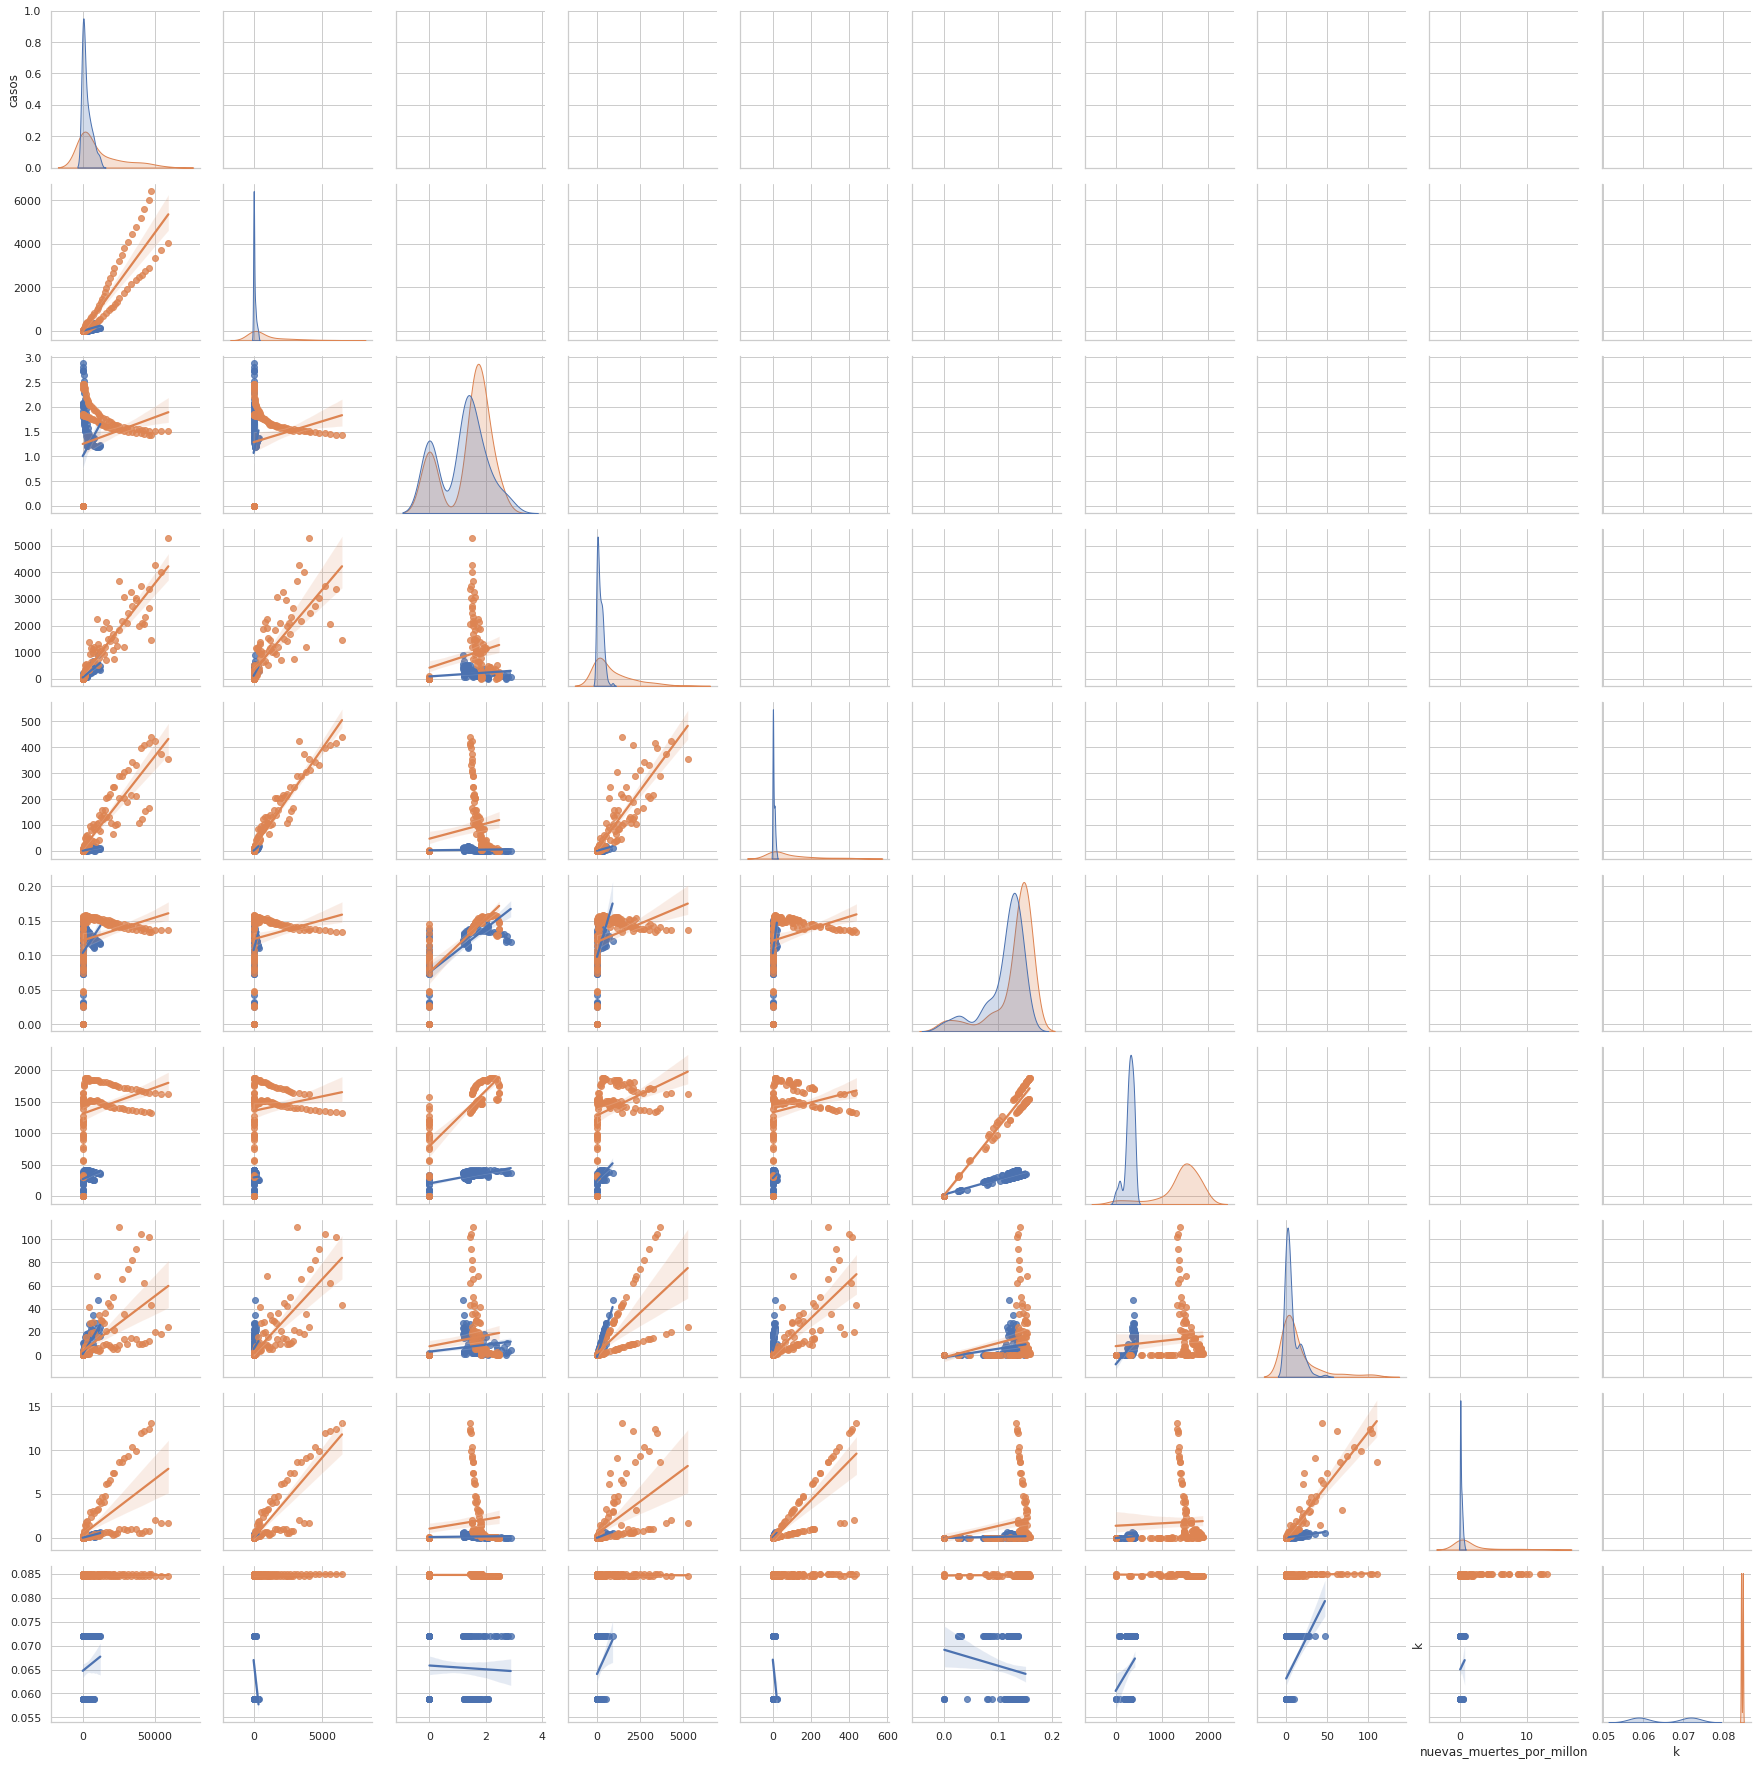

In [192]:
sns.set(style="whitegrid", font_scale=1.0)
#sns.set()
sns.pairplot(df_out_indicadores,vars=['casos','muertes','tasa_rep','nuevos_casos','nuevas_muertes','var_k','var_k_esc','nuevos_casos_por_millon','nuevas_muertes_por_millon','k'],hue = 'cuarentena',kind = "reg")
#sns.pairplot(df4_filtrado, vars=["rooms", "bedrooms","bathrooms","surface_total","surface_covered","price"],hue = 'property_type')
plt.show()

Correlacion Pearson

In [193]:
df1 = df_out_indicadores[['casos','muertes','nuevos_casos','nuevas_muertes','tasa_rep','k','var_k','var_k_esc','cuarentena']]
df1.corr()

,casos,muertes,nuevos_casos,nuevas_muertes,tasa_rep,k,var_k,var_k_esc,cuarentena
casos,1.000000,0.912788,0.924008,0.905033,0.201855,0.331247,0.275107,0.439227,0.357202
muertes,0.912788,1.000000,0.832343,0.969103,0.156831,0.353245,0.226610,0.412041,0.398714
nuevos_casos,0.924008,0.832343,1.000000,0.882028,0.245453,0.380502,0.315495,0.507413,0.409725
nuevas_muertes,0.905033,0.969103,0.882028,1.000000,0.190498,0.401326,0.268059,0.478335,0.448717
tasa_rep,0.201855,0.156831,0.245453,0.190498,1.000000,0.105094,0.761503,0.444269,0.133782
k,0.331247,0.353245,0.380502,0.401326,0.105094,1.000000,0.141887,0.786469,0.901813
var_k,0.275107,0.226610,0.315495,0.268059,0.761503,0.141887,1.000000,0.591906,0.213680
var_k_esc,0.439227,0.412041,0.507413,0.478335,0.444269,0.786469,0.591906,1.000000,0.860251
cuarentena,0.357202,0.398714,0.409725,0.448717,0.133782,0.901813,0.213680,0.860251,1.000000


Heatmap con las correlaciones de las variables estudiadas

In [194]:
matriz_corr = df1.corr()

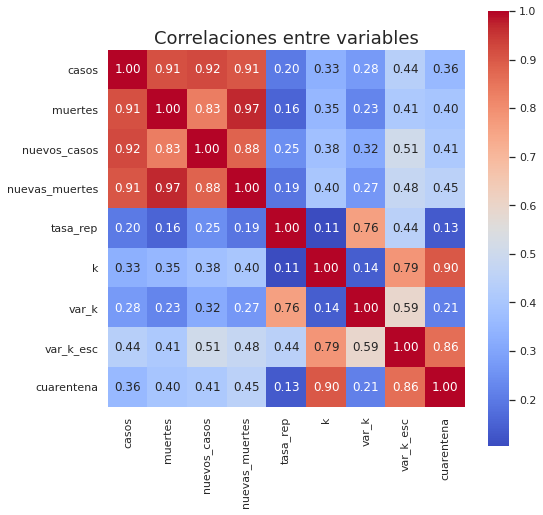

In [195]:
plt.figure(figsize=(8,8))
fig.tight_layout(pad=5.0)
plt.title("Correlaciones entre variables", fontsize=18)
sns.heatmap(matriz_corr,cbar = True,  square = True, annot=True, fmt= '.2f',cmap= 'coolwarm')
#plt.xticks(rotation = 45)
#plt.yticks(rotation = 45)
plt.show()

Una correlación negativa (inversa) se produce cuando el coeficiente de correlación es inferior a 0. Esto es una indicación de que ambas variables se mueven en la dirección opuesta. En resumen, cualquier lectura entre 0 y -1 significa que los dos valores se mueven en direcciones opuestas, es decir si hubo cuarentena el valor de k será menor, li mismo la tasa_rep y la cantidad de nuevas_muertes

#### **h.5 Creación Modelo con Regresión Logística** <a class="anchor" id="section_2_3_5"></a>
[Tabla de contenidos](#TOC)

Definimos la función sigmoide

In [196]:
def sigmoid_function(x,w0, w1):
    '''Equivalente a perceptron con funcion de activacion sigmoide'''    
    z = w0 + w1*x 
    y = 1/(1 + np.exp(-z))   
    return y

Graficamos Cuerentena Vs Valor de la variabilidad de k

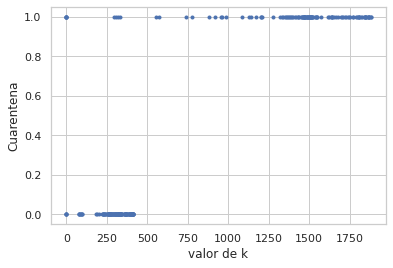

In [260]:
plt.plot(df_out_indicadores['var_k_esc'].values,df_out_indicadores['cuarentena'].values,'.')
plt.xlabel('valor de k')
plt.ylabel('Cuarentena')
plt.show()

Difinimos nuestras X e y

In [261]:
X = df_out_indicadores['var_k_esc'].values.reshape(-1,1)
y = df_out_indicadores['cuarentena'].values.reshape(-1,1)
#X.shape
#y.shape

Entrenamos una regresion logistica

In [262]:
### Entrenamos una regresion logistica
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X,y)

LogisticRegression()

Predecimos y medimos la precisión:

In [263]:
### predecimos
prediccion = regresion_logistica.predict(X)
accuracy_score(y, prediccion)

0.9541666666666667

Veamos los parámetros obtenidos:

In [264]:
print(regresion_logistica.coef_, regresion_logistica.intercept_)

[[0.00635808]] [-4.21327562]


Con estos parámetros, podemos graficar la curva obtenida por la regresión logística. Ojo, ésta NO es la frontera de decisión. Usamos la función que definimos más arriba, sigmoid_function.

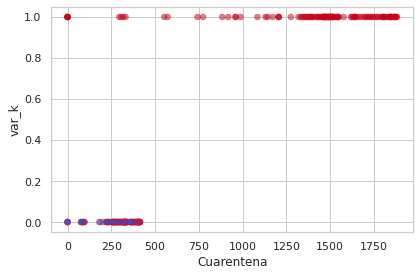

In [268]:
X = df_out_indicadores['var_k_esc'].values
y = df_out_indicadores['cuarentena'].values

plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'red', cmap =cm.coolwarm)

x_plot = np.linspace(0,1,10)
plt.plot(x_plot, sigmoid_function(x_plot,regresion_logistica.intercept_[0], regresion_logistica.coef_[0][0]))

plt.xlabel('Cuarentena')
plt.ylabel('var_k')
plt.tight_layout()
plt.show()

Matriz de correlación entre le valor de k y cuarentena

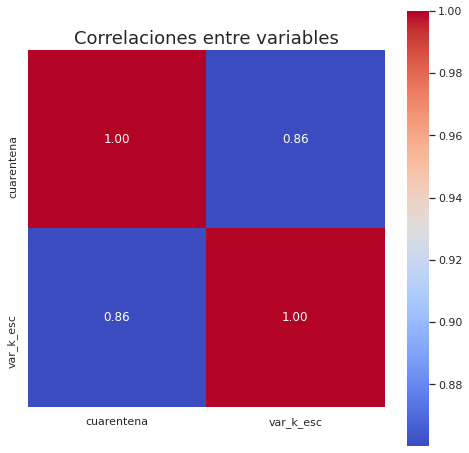

In [269]:
matriz_corr = df1[['cuarentena','var_k_esc']].corr()

plt.figure(figsize=(8,8))
fig.tight_layout(pad=5.0)
plt.title("Correlaciones entre variables", fontsize=18)
sns.heatmap(matriz_corr,cbar = True,  square = True, annot=True, fmt= '.2f',cmap= 'coolwarm')
#plt.xticks(rotation = 45)
#plt.yticks(rotation = 45)
plt.show()

Vemos que no hay correlación, así que descartamos esté indicador, además tiene una baja precisión.

Probamos con el indicador de K indicadores

In [270]:
X = df_out_indicadores['k'].values.reshape(-1,1)
y = df_out_indicadores['cuarentena'].values.reshape(-1,1)
#X.shape
#y.shape


In [271]:
### Entrenamos una regresion logistica
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X,y)

LogisticRegression()

In [272]:
### predecimos
prediccion = regresion_logistica.predict(X)
accuracy_score(y, prediccion)

1.0

Vemos los parametros obtenidos

In [273]:
print(regresion_logistica.coef_[0][0], regresion_logistica.intercept_[0])

1.1539863958424021 -0.08662369478717313


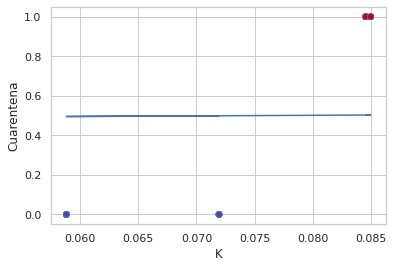

In [275]:
#plt.plot(X,y,'.')
plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)
#x_plot = np.linspace(0,1,0)

plt.plot(X, sigmoid_function(X, regresion_logistica.intercept_[0], regresion_logistica.coef_[0][0]))
#plt.legend()
plt.xlabel('K')
plt.ylabel('Cuarentena')
plt.show()

Probabilidad de la predicción, con el indicador K

In [209]:
probabilidades_prediccion = regresion_logistica.predict_proba(X)

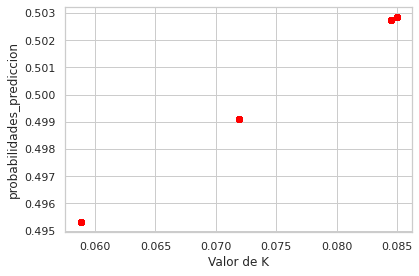

In [210]:
#plt.scatter(X, y, c = y, alpha = 0.5, lw = 0.5, edgecolor = 'grey', cmap =cm.coolwarm)
x_plot = X
y_plot = probabilidades_prediccion[:,1]
plt.scatter(x_plot, y_plot, alpha = 0.5, color = 'red')

plt.xlabel('Valor de K')
plt.ylabel('probabilidades_prediccion')
plt.tight_layout()
plt.show()

#### **h.6 Clasificación con el modelo de Regresión Logística** <a class="anchor" id="section_2_3_6"></a>
[Tabla de contenidos](#TOC)

Los 3 primeros paises de la lista a continuación realizaron cuarentenas estrictas y los 2 últimos no. Veremos como funciona nuestro clasificador:

In [211]:
list_test = ['Honduras','Peru','Ecuador','South Korea','Taiwan']

In [212]:
df_out_indicadores_test = pd.DataFrame()

for x_pais in tqdm(list_test):
    #print(x_pais)
    df_analizar_pais,df_analizar_pais_mean,df_analizar_pais_max = analizar_pais_df(x_pais,0,110,0,30,17,25) 
    df_out_indicadores_test = df_out_indicadores_test.append(df_analizar_pais_max)
df_out_indicadores_test

100%|██████████| 5/5 [00:00<00:00, 20.48it/s]


,pais,casos,muertes,tasa_rep,nuevos_casos,nuevas_muertes,nuevos_casos_por_millon,nuevas_muertes_por_millon,k,var_k,var_k_esc
0,Honduras,436.533333,32.583333,1.36,224.0,10.0,22.260,0.994,0.067592,0.122668,53.483262
0,Peru,9915.650000,1245.566667,1.85,3683.0,438.0,110.404,13.130,0.084959,0.156169,1548.415767
0,Ecuador,5211.600000,201.816667,1.98,11536.0,208.0,644.885,11.628,0.087682,0.156800,817.085940
0,South Korea,2731.750000,22.250000,5.96,851.0,11.0,16.587,0.214,0.063201,0.135920,371.196593
0,Taiwan,33.383333,0.616667,1.05,27.0,1.0,1.132,0.042,0.059031,0.075072,2.477392


Definimos los nuevos X e y

In [237]:
X = df_out_indicadores_test['k'].values.reshape(-1, 1)
y = ['1','1','1','0','0']

In [246]:
X.dtype

dtype('float64')

In [251]:
y = y.astype(float)

In [252]:
y = np.array(y)
y.dtype

dtype('float64')

In [253]:
prediccion = regresion_logistica.predict(X)

In [254]:
prediccion

array([0, 1, 1, 0, 0])

In [255]:
accuracy_score(y, prediccion)

0.8

In [256]:
prediccion

array([0, 1, 1, 0, 0])

#### **i. Que clasificador funcionó mejor** <a class="anchor" id="section_2_4"></a>
[Tabla de contenidos](#TOC)

#### **i.1 Clasificador 1** <a class="anchor" id="section_2_4_1"></a>
[Tabla de contenidos](#TOC)

#### **i.2 Clasificador 2** <a class="anchor" id="section_2_4_2"></a>
[Tabla de contenidos](#TOC)

### **Investigación** <a class="anchor" id="chapter3"></a>
[Tabla de contenidos](#TOC)

#### **j. Plantea nuevas preguntas en base al trabajo que hiciste y en las que se pueda ahondar** <a class="anchor" id="section_3_1"></a>
[Tabla de contenidos](#TOC)

#### **k. Informe final** <a class="anchor" id="section_3_2"></a>
[Tabla de contenidos](#TOC)

### **Requerimientos adicionales** <a class="anchor" id="chapter4"></a>
[Tabla de contenidos](#TOC)

#### **l. Fuentes e Información adicional** <a class="anchor" id="section_3_1"></a>
[Tabla de contenidos](#TOC)